<img src="https://www.energydaily.co.kr/news/photo/202211/132051_86204_1454.jpg" width=600 height=400>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


>본 대회는 재생에너지 발전소 정산금 예측을 위한 정산금 예측 AI 모델을 개발하는 대회입니다.

# 목차

>## I. Abstract

>## II. 환경설정

>## III. 기존 데이터 확인 및 분석
>>## i. 기존데이터 확인  
>>## ii. 기존데이터 분석
>>>1. 거시적 분석
>>>2. 미시적 분석

>## IV. 기존 데이터 수정 및 분석
>>## i. 기존 데이터 수정
>>>1. type conversion and replace error data
>>>2. datetime for index
>>>3. gap 오차율 계산

>>## ii. 기존 데이터 수정본 분석
>>>1. 발전소 코드별로 시계열 데이터 시각화  

>## V. 모델링
>>## i. 기존 데이터 수정본 분석  
>>## ii. 최적의 클러스터 계수 찾기
>>>1. KMeans
>>>2. Gaussian Mixture
>>>3. Hierarchy Clustering  
>>## iii. 클러스터링 알고리즘 적용
>>>1. KMeans
>>>2. Gaussian Mixture
>>>3. Hierarchy Clustering  
>>>4. DBSCAN
>>## iv. Sihouette 계수를 이용하여 적합성을 확인
>## VI. 결론
>>## i. Summary
>>## ii. 향후 모델 활용 방안

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# I. Abstract

>1. 기존 제공된 데이터와 추가 데이터를 통한 경향 및 특징을 분석하였다.

>2. 각각의 clustering 알고리즘으로 유연한 모델링을 통한 발전소 코드별 정산금 예측 모델을 완성했다.

# II. 환경설정

>## 1. 필요 library를 설치합니다.

In [3]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install tslearn
!pip install sklearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 2.7 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


>## 2. 사용할 library를 import 합니다.

In [4]:
# 용도별 사용할 lib들은 하기와 같습니다.

# Native libraries
import os
import math

# 데이터 처리
import pandas as pd
import numpy as np
from numpy import where
from numpy import unique
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 데이터 시각화
import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm


# 모델링을 위한 패키지
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict, KFold
from sklearn import metrics
!pip install tslearn
import tslearn
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# # 한글 폰트 설정 (에러가 날시에는 아래 3줄 주석처리)
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# plt.rc('font', family='NanumGothic')


# # warnings 무시
# import os
# import warnings
# warnings.filterwarnings(action='ignore')

# III. 기존데이터 확인 및 분석

># i. 데이터 확인

>>## 1. 먼저 기존데이터를 불러옵니다.

In [5]:
all_mySeries = []       # 실측 + 예측 데이터의 집합입니다.
actual_mySeries = []    # 실측 데이터 프레임의 집합입니다.
predict_mySeries = []   # 예측 데이터 프레임의 집합입니다.

df = pd.read_csv('/content/drive/MyDrive/DEVDAY/제11회 산업통상자원부 공공데이터활용 BI공모전_빅데이터 분석 과제 5_데이터.csv')
df = df.sort_values(by=['일자', '발전소코드'])  # 일자별 발전소코드별 순서로 정렬합니다.

>>## 2. 데이터의 shape을 확인합니다.
>>(1) 테이블 크기 : 10,478개의 행과 30개의 컬럼으로 구성되어 있습니다.  
>>(2) 각 컬럼들의 자료형태 : datetime 형 컬럼(1개), 실수형 컬럼(26개), 문자형 컬럼(3개)로 구성되어 있습니다.

In [6]:
display(df.shape)  # df의 (행의 크기, 열의 크기) 를 나타냅니다.

(10478, 29)

In [7]:
display(df.info()) # df의 정보를 나타냅니다.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10478 entries, 7728 to 10291
Data columns (total 29 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   일자         10478 non-null  object 
 1   구분1        10478 non-null  object 
 2   발전소코드      10478 non-null  object 
 3   발전소용량(KW)  10478 non-null  float64
 4   0:00       10478 non-null  float64
 5   1:00       10478 non-null  float64
 6   2:00       10478 non-null  object 
 7   3:00       10478 non-null  object 
 8   4:00       10478 non-null  object 
 9   5:00       10478 non-null  float64
 10  6:00       10478 non-null  float64
 11  7:00       10478 non-null  float64
 12  8:00       10478 non-null  float64
 13  9:00       10478 non-null  float64
 14  10:00      10478 non-null  float64
 15  11:00      10478 non-null  float64
 16  12:00      10478 non-null  float64
 17  13:00      10478 non-null  float64
 18  14:00      10478 non-null  float64
 19  15:00      10478 non-null  float64
 20  16:

None

> 기본 데이터 column 명은 다음과 같습니다.
- 일자 : 연-월-일
- 구분1 : 실측 발전량, 예측 발전량 구분
- 발전소코드 : 발전소코드
- 발전소용량(KW) : 발전소용량
- 0:00 : 0시
- 1:00 : 1시
- 2:00 : 2시
- 3:00 : 3시
- 4:00 : 4시
- 5:00 : 5시
- 6:00 : 6시
- 7:00 : 7시
- 8:00 : 8시
- 9:00 : 9시
- 10:00 : 10시
- 11:00 : 11시
- 12:00 : 12시
- 13:00 : 13시
- 14:00 : 14시
- 15:00 : 15시
- 16:00 : 16시
- 17:00 : 17시
- 18:00 : 18시
- 19:00 : 19시
- 20:00 : 20시
- 21:00 : 21시
- 22:00 : 22시
- 23:00 : 23시


>>## 3. descriptive statistics

In [8]:
df.describe()  # 데이터를 통계적으로 요약합니다.

,발전소용량(KW),0:00,1:00,5:00,6:00,7:00,8:00,9:00,10:00,11:00,12:00,13:00,14:00,15:00,16:00,17:00,18:00,19:00,합계
count,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000
mean,1170.411982,5.535597,3.847895,1.395616,3.069223,60.709166,230.756914,433.839777,313.126047,350.998824,374.875136,401.338597,520.174993,478.605848,334.019033,291.713824,267.849389,266.224908,5041.149679
std,932.526816,48.389084,34.226139,12.300487,14.658899,72.813683,249.648959,434.088599,323.059084,377.327086,403.090053,410.579014,560.317087,502.262720,336.108086,651.184268,563.302526,546.779677,4747.085174
min,98.825000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.480000,0.000000,0.000000,0.000000,49.200000
25%,496.000000,0.000000,0.000000,0.000000,0.000000,16.270000,69.260000,155.202500,76.510000,82.747500,89.555000,114.700000,153.625000,153.870000,113.392500,43.992500,4.340000,0.000000,1988.877500
50%,956.160000,0.000000,0.000000,0.000000,0.480000,35.525000,149.425000,304.465000,235.040000,254.560000,275.485000,300.345000,364.825000,327.035000,235.115000,99.080000,11.430000,0.000000,3715.665000
75%,1200.000000,0.000000,0.000000,0.000000,3.180000,76.947500,282.760000,503.562500,478.032500,534.120000,573.585000,598.975000,641.607500,557.977500,393.955000,230.920000,52.375000,223.020000,5550.300000
max,5587.560000,1601.800000,799.000000,410.000000,611.000000,663.480000,3706.640000,3595.180000,3109.890000,3436.540000,4391.340000,4292.900000,4719.310000,3836.320000,3084.960000,46445.330000,3467.480000,3354.770000,57533.930000


In [9]:
df['9:00'].describe()

count    10478.000000
mean       433.839777
std        434.088599
min          0.000000
25%        155.202500
50%        304.465000
75%        503.562500
max       3595.180000
Name: 9:00, dtype: float64

In [10]:
df['10:00'].describe()

count    10478.000000
mean       313.126047
std        323.059084
min          0.000000
25%         76.510000
50%        235.040000
75%        478.032500
max       3109.890000
Name: 10:00, dtype: float64

In [11]:
df['11:00'].describe()

count    10478.000000
mean       350.998824
std        377.327086
min          0.000000
25%         82.747500
50%        254.560000
75%        534.120000
max       3436.540000
Name: 11:00, dtype: float64

In [12]:
df['12:00'].describe()

count    10478.000000
mean       374.875136
std        403.090053
min          0.000000
25%         89.555000
50%        275.485000
75%        573.585000
max       4391.340000
Name: 12:00, dtype: float64

In [13]:
df['13:00'].describe()

count    10478.000000
mean       401.338597
std        410.579014
min          0.000000
25%        114.700000
50%        300.345000
75%        598.975000
max       4292.900000
Name: 13:00, dtype: float64

In [14]:
df['14:00'].describe()

count    10478.000000
mean       520.174993
std        560.317087
min          0.000000
25%        153.625000
50%        364.825000
75%        641.607500
max       4719.310000
Name: 14:00, dtype: float64

>>## 3. 결측치를 확인합니다.
>>### 확인결과 모든 컬럼에 결측치가 없음을 확인하였습니다.

In [15]:
#결측데이터 유무 확인 함수
def nan_counter(series):
    nan_polluted_series_counter = 0

    if series.isnull().sum().sum() > 0:
        nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [16]:
nan_counter(df)

0


># IV. 기존 데이터 수정 및 분석

># i. 기존 데이터 수정

>>## 1.  type conversion and replace error data

In [17]:
## replace '-'
df = df.replace('-', 0)

In [18]:
# 열별로 데이터형 변환할 딕셔너리 생성
dtype_mapping = {
    '2:00': float,
    '3:00': float,
    '4:00': float,
    '20:00': float,
    '21:00': float,
    '22:00': float,
    '23:00': float
}

# 여러 개의 열을 한꺼번에 데이터형 변환
df = df.astype(dtype_mapping)

In [19]:
df.dtypes  # 데이터타입 확인

일자            object
구분1           object
발전소코드         object
발전소용량(KW)    float64
0:00         float64
1:00         float64
2:00         float64
3:00         float64
4:00         float64
5:00         float64
6:00         float64
7:00         float64
8:00         float64
9:00         float64
10:00        float64
11:00        float64
12:00        float64
13:00        float64
14:00        float64
15:00        float64
16:00        float64
17:00        float64
18:00        float64
19:00        float64
20:00        float64
21:00        float64
22:00        float64
23:00        float64
합계           float64
dtype: object

In [20]:
time_columns = df.columns[4:28] # 시간대 컬럼 생성을 합니다.

In [21]:
print(time_columns)

Index(['0:00', '1:00', '2:00', '3:00', '4:00', '5:00', '6:00', '7:00', '8:00',
       '9:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00',
       '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'],
      dtype='object')


>>## 2.  datetime for index

In [22]:
# 일자와 시간의 값을 합치고 datetime 컬럼 생성
df['date'] = pd.to_datetime(df['일자'])
time_columns = df.columns[4:28]
df2 = df.melt(id_vars=['일자', '구분1', '발전소코드', '발전소용량(KW)'], value_vars=time_columns, var_name='hour', value_name='value')
df2['datetime'] = pd.to_datetime(df2['일자'].astype(str) + ' ' + df2['hour'], format='%Y-%m-%d %H')

In [23]:
display(df2)

,일자,구분1,발전소코드,발전소용량(KW),hour,value,datetime
0,2023-03-01,실측,B1727,1642.500,0:00,0.00,2023-03-01 00:00:00
1,2023-03-01,예측,B1727,1642.500,0:00,0.00,2023-03-01 00:00:00
2,2023-03-01,실측,B1728,2082.080,0:00,0.00,2023-03-01 00:00:00
3,2023-03-01,예측,B1728,2082.080,0:00,2.85,2023-03-01 00:00:00
4,2023-03-01,실측,B1729,2919.525,0:00,0.00,2023-03-01 00:00:00
...,...,...,...,...,...,...,...
251467,2023-03-31,예측,V9025,940.800,23:00,84.87,2023-03-31 23:00:00
251468,2023-03-31,실측,V9026,940.800,23:00,124.38,2023-03-31 23:00:00
251469,2023-03-31,예측,V9026,940.800,23:00,232.82,2023-03-31 23:00:00
251470,2023-03-31,실측,V9027,470.000,23:00,0.00,2023-03-31 23:00:00


>>## 3. gap 오차율 계산

In [24]:
# 'datetime', '발전소코드', '발전소용량(KW)'를 인덱스 열로 사용하여 데이터프레임을 피벗합니다.
# '구분1'을 피벗할 열로 사용하고, 해당하는 값은 'value'에서 가져옵니다.
# reset_index()는 피벗된 데이터프레임의 인덱스를 재설정하여 인덱스 열을 일반 열로 변환합니다.
df_combined = df2.pivot(index=['datetime', '발전소코드', '발전소용량(KW)'], columns='구분1', values='value').reset_index()
df_combined['gap'] = abs((df_combined['실측'] - df_combined['예측'])) / df_combined['발전소용량(KW)'] * 100
df_combined['actual_average'] = df_combined['실측']
df_combined['predict_average'] = df_combined['예측']

In [25]:
df_combined.set_index('datetime') # df_combined datatime을 인덱스로 지정해줍니다.

구분1,발전소코드,발전소용량(KW),실측,예측,gap,actual_average,predict_average
datetime,,,,,,,
2023-03-01 00:00:00,B1727,1642.500,0.00,0.00,0.000000,0.00,0.00
2023-03-01 00:00:00,B1728,2082.080,0.00,2.85,0.136882,0.00,2.85
2023-03-01 00:00:00,B1729,2919.525,0.00,3.50,0.119883,0.00,3.50
2023-03-01 00:00:00,B1730,737.870,0.00,1.39,0.188380,0.00,1.39
2023-03-01 00:00:00,B1731,2956.875,0.00,8.94,0.302346,0.00,8.94
...,...,...,...,...,...,...,...
2023-03-31 23:00:00,V9023,2499.840,0.00,0.00,0.000000,0.00,0.00
2023-03-31 23:00:00,V9024,940.800,222.73,254.06,3.330145,222.73,254.06
2023-03-31 23:00:00,V9025,940.800,73.04,84.87,1.257440,73.04,84.87


In [26]:
df_combined["hour"] = df_combined['datetime'].dt.hour

In [27]:
display(df_combined['hour'])

0          0
1          0
2          0
3          0
4          0
          ..
125731    23
125732    23
125733    23
125734    23
125735    23
Name: hour, Length: 125736, dtype: int64

In [28]:
df_combined['실측']

0           0.00
1           0.00
2           0.00
3           0.00
4           0.00
           ...  
125731      0.00
125732    222.73
125733     73.04
125734    124.38
125735      0.00
Name: 실측, Length: 125736, dtype: float64

In [29]:
df_predict = df_combined.pivot(index='datetime', columns='발전소코드', values='예측')

# 인덱스를 시간대로 바꾸기위해 재설정해줍니다.
df_predict = df_predict.reset_index()
df_predict["hour"] = df_predict['datetime'].astype("datetime64").dt.hour
display(df_predict)

<ipython-input-29-8370f8a7c3f9>:5: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  df_predict["hour"] = df_predict['datetime'].astype("datetime64").dt.hour


발전소코드,datetime,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,...,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027,hour
0,2023-03-01 00:00:00,0.00,2.85,3.50,1.39,8.94,1.63,2.94,1.32,6.88,...,0.0,3.75,0.0,0.0,0.0,4.80,4.01,4.03,0.0,0
1,2023-03-01 01:00:00,0.00,3.08,3.47,1.37,3.78,1.43,2.91,1.36,6.92,...,0.0,3.83,0.0,0.0,0.0,4.15,3.95,3.82,0.0,1
2,2023-03-01 02:00:00,0.00,3.10,3.48,1.37,3.72,1.37,2.98,1.39,6.95,...,0.0,3.77,0.0,0.0,0.0,4.12,3.98,3.88,0.0,2
3,2023-03-01 03:00:00,0.00,3.21,3.53,1.36,3.69,1.33,3.00,1.30,6.82,...,0.0,3.81,0.0,0.0,0.0,4.17,3.94,3.94,0.0,3
4,2023-03-01 04:00:00,0.00,3.15,3.56,1.36,3.62,1.35,2.92,1.30,6.64,...,0.0,3.58,0.0,0.0,0.0,4.11,4.02,3.99,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2023-03-31 19:00:00,0.02,1197.80,1645.46,470.83,1640.17,484.18,1387.31,314.31,3144.19,...,0.0,1533.62,0.0,0.0,0.0,453.50,478.75,439.25,0.0,19
740,2023-03-31 20:00:00,0.00,1179.07,1594.23,458.07,1634.22,468.87,1355.96,307.28,3076.18,...,0.0,1504.18,0.0,0.0,0.0,474.88,499.90,463.16,0.0,20
741,2023-03-31 21:00:00,0.00,1165.79,1579.88,144.37,1628.01,464.82,1340.95,303.50,2880.33,...,0.0,1487.31,0.0,0.0,0.0,471.95,497.45,463.18,0.0,21
742,2023-03-31 22:00:00,0.00,377.28,311.02,9.93,151.40,80.99,730.43,7.62,95.55,...,0.0,758.22,0.0,0.0,0.0,468.96,495.43,464.05,0.0,22


In [30]:
df_predict = df_predict.drop(columns=['datetime']).groupby('hour').sum()

In [31]:
df_actual = df_combined.pivot(index='datetime', columns='발전소코드', values='실측')

# 인덱스를 시간대로 바꾸기위해 재설정해줍니다.
df_actual = df_actual.reset_index()
df_actual["hour"] = df_actual['datetime'].astype("datetime64").dt.hour
display(df_actual)

<ipython-input-31-ef9df1e241ec>:5: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  df_actual["hour"] = df_actual['datetime'].astype("datetime64").dt.hour


발전소코드,datetime,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,...,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027,hour
0,2023-03-01 00:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0
1,2023-03-01 01:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,1
2,2023-03-01 02:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,2
3,2023-03-01 03:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,3
4,2023-03-01 04:00:00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2023-03-31 19:00:00,0.0,1242.0,1464.00,428.62,1468.32,437.83,1293.36,290.06,2952.96,...,0.0,1458.72,0.0,0.0,0.0,429.56,459.21,437.51,0.0,19
740,2023-03-31 20:00:00,0.0,1238.4,1463.76,412.13,1468.80,437.83,1293.60,290.35,2940.48,...,0.0,1458.48,0.0,0.0,0.0,461.38,490.30,457.76,0.0,20
741,2023-03-31 21:00:00,0.0,1240.2,651.12,41.33,896.40,293.11,1126.08,166.90,1460.64,...,0.0,594.72,0.0,0.0,0.0,459.93,488.86,456.31,0.0,21
742,2023-03-31 22:00:00,0.0,889.2,0.00,0.00,63.84,20.45,175.68,7.73,74.88,...,0.0,0.00,0.0,0.0,0.0,459.21,488.86,455.59,0.0,22


In [32]:
df_actual = df_actual.drop(columns=['datetime']).groupby('hour').sum()

In [33]:
df_actual

발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
hour,,,,,,,,,,,,,,,,,,,,,
0,0.0,550.8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
1,0.0,63.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
2,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
3,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
4,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
5,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
6,54.0,52.2,13.68,13.95,54.96,9.34,56.64,2.93,91.68,4.8,...,36.00,36.00,62.88,0.00,116.43,126.0,25.31,30.36,31.10,6.29
7,2558.4,1650.6,2941.20,1033.64,3859.44,993.10,4022.88,583.14,7315.68,1675.2,...,1247.04,1161.36,4172.16,433.55,3234.69,5659.2,655.93,829.48,740.54,649.96
8,10106.4,6526.8,14506.80,4308.82,16248.48,4490.44,16932.00,2832.61,31750.56,8486.4,...,4814.64,4509.36,16992.24,3775.08,8870.99,20806.2,2333.64,4166.14,3411.13,3274.26


># ii. 기존 데이터 수정본 분석

>>## 1. 발전소 코드별로 시계열 데이터 시각화

<ipython-input-34-b0b7b7785d0a>:30: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  plt.tight_layout()
<ipython-input-34-b0b7b7785d0a>:30: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  plt.tight_layout()
<ipython-input-34-b0b7b7785d0a>:30: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48156 (\N{HANGUL SYLLABLE BAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


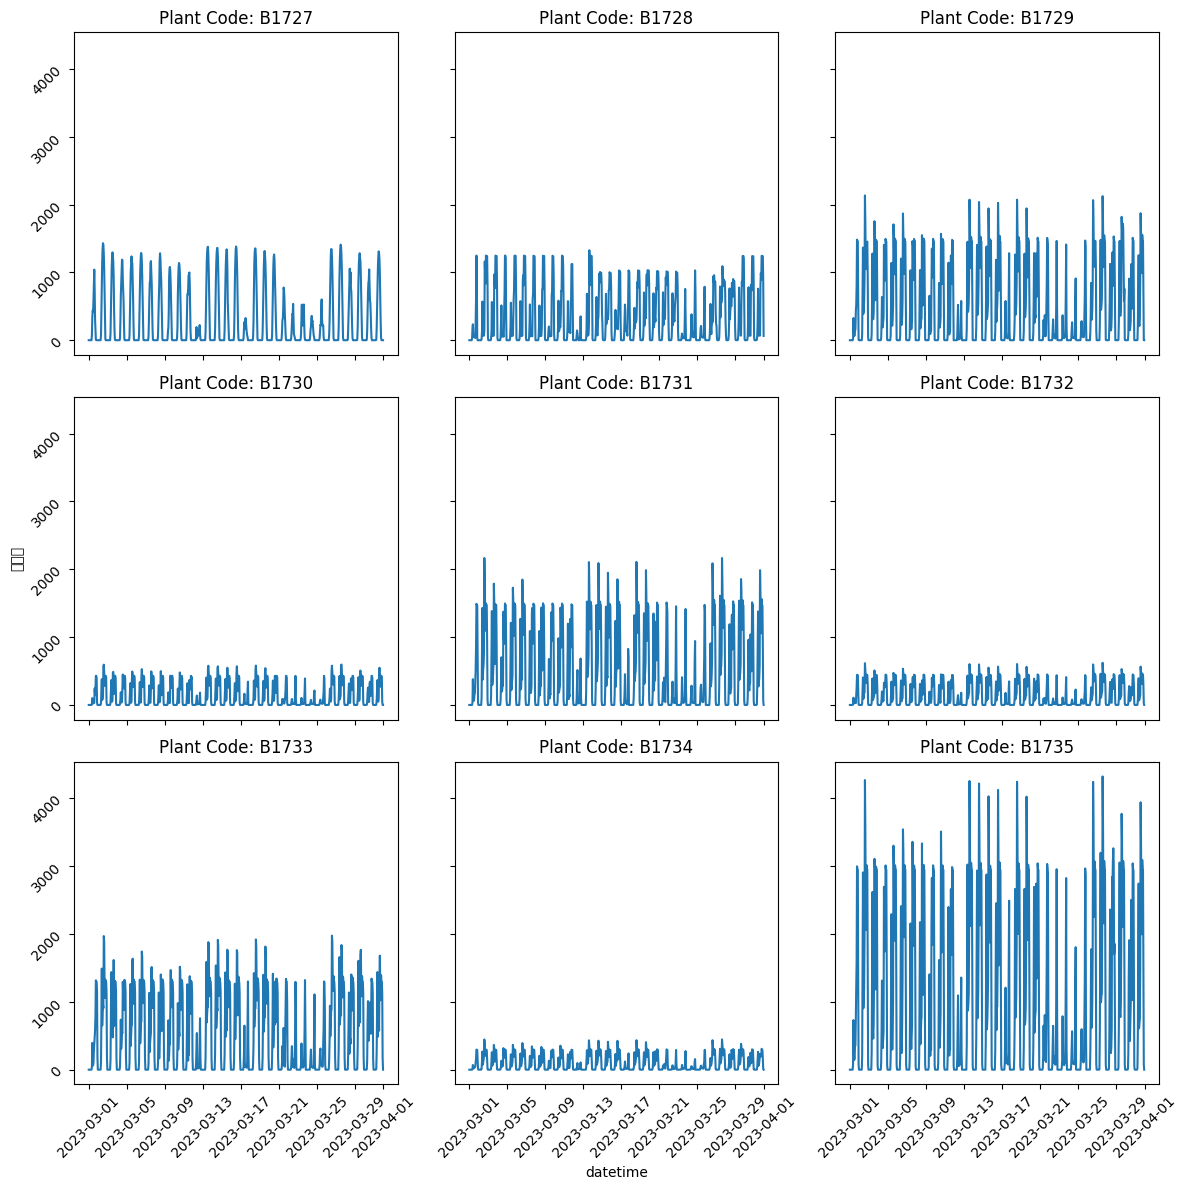

In [34]:
unique_codes = df_combined['발전소코드'].unique() # '발전소코드' 컬럼에서 고유한 값들을 추출하여 배열로 저장합니다.
num_plots = 9
num_rows = 3
num_cols = 3

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12), sharex=True, sharey=True)

# unique_codes 배열에서 num_plots 개수만큼의 값에 대해 반복합니다.
for i, code in enumerate(unique_codes[:num_plots]):
    # 현재 반복 인덱스를 이용하여 그래프의 행(row)과 열(col) 위치를 계산합니다.
    row = i // num_cols
    col = i % num_cols

    # df_combined에서 '발전소코드' 컬럼이 현재 코드와 일치하는 행들로 이루어진 부분집합(df_subset)을 만듭니다.
    df_subset = df_combined[df_combined['발전소코드'] == code]

    # axs[row, col]에 대해 그래프를 그립니다. x축은 'datetime', y축은 '실측'으로 설정합니다.
    axs[row, col].plot(df_subset['datetime'], df_subset['실측'])

    # 그래프의 제목을 현재 발전소 코드를 포함한 형식으로 설정합니다.
    axs[row, col].set_title(f'Plant Code: {code}')

    # x축 라벨들을 보기좋게 기울입니다.
    axs[row, col].tick_params(labelrotation=45)



axs[2][1].set_xlabel('datetime')
axs[1][0].set_ylabel('발전량')
plt.tight_layout()
plt.show()

# V. 모델링

우리는 모델링을 4개의 Clustering 알고리즘으로 데이터셋 훈련을 시킨 후 예측 정산금을 비교했습니다.
- 먼저 시계열 클러스터링을 하기위해 시간대별로 데이터셋을 수정하였습니다.
- 그리고 이를 바탕으로 최종데이터셋을 도출한 후에 Time Series Clustering 모델을 사용하여 '최적 예측형 집합자원'를 예측할 것입니다.

># i. 기본 데이터 수정본 전처리  

In [35]:
df_combined["hour"] = df_combined['datetime'].dt.hour

In [36]:
display(df_combined['hour'])

0          0
1          0
2          0
3          0
4          0
          ..
125731    23
125732    23
125733    23
125734    23
125735    23
Name: hour, Length: 125736, dtype: int64

In [37]:
# 'df_combined' 데이터프레임을 피벗합니다.
# 'datetime'을 인덱스로, '발전소코드'를 컬럼으로, 'gap'을 값으로 사용합니다.
df_pivot = df_combined.pivot(index='datetime', columns='발전소코드', values='gap')

# 인덱스를 시간대로 바꾸기위해 재설정해줍니다.
df_pivot = df_pivot.reset_index()
df_pivot["hour"] = df_pivot['datetime'].astype("datetime64").dt.hour
display(df_pivot)

<ipython-input-37-853787a616bc>:7: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  df_pivot["hour"] = df_pivot['datetime'].astype("datetime64").dt.hour


발전소코드,datetime,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,...,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027,hour
0,2023-03-01 00:00:00,0.000000,0.136882,0.119883,0.188380,0.302346,0.182176,0.103572,0.234221,0.123131,...,0.0,0.133881,0.0,0.0,0.0,0.510204,0.426233,0.428359,0.0,0
1,2023-03-01 01:00:00,0.000000,0.147929,0.118855,0.185670,0.127838,0.159823,0.102515,0.241319,0.123847,...,0.0,0.136737,0.0,0.0,0.0,0.441114,0.419855,0.406037,0.0,1
2,2023-03-01 02:00:00,0.000000,0.148890,0.119197,0.185670,0.125808,0.153117,0.104981,0.246642,0.124383,...,0.0,0.134595,0.0,0.0,0.0,0.437925,0.423044,0.412415,0.0,2
3,2023-03-01 03:00:00,0.000000,0.154173,0.120910,0.184314,0.124794,0.148647,0.105686,0.230672,0.122057,...,0.0,0.136023,0.0,0.0,0.0,0.443240,0.418793,0.418793,0.0,3
4,2023-03-01 04:00:00,0.000000,0.151291,0.121938,0.184314,0.122427,0.150882,0.102868,0.230672,0.118835,...,0.0,0.127811,0.0,0.0,0.0,0.436862,0.427296,0.424107,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,2023-03-31 19:00:00,0.001218,2.122877,6.215395,5.720520,5.811879,5.180276,3.309730,4.302926,3.422424,...,0.0,2.674045,0.0,0.0,0.0,2.544643,2.076956,0.184949,0.0,19
740,2023-03-31 20:00:00,0.000000,2.849554,4.468878,6.226029,5.594420,3.469164,2.196858,3.004063,2.428609,...,0.0,1.631560,0.0,0.0,0.0,1.434949,1.020408,0.573980,0.0,20
741,2023-03-31 21:00:00,0.000000,3.573830,31.812024,13.964519,24.742676,19.191050,7.569577,24.238338,25.408049,...,0.0,31.866833,0.0,0.0,0.0,1.277636,0.913053,0.730230,0.0,21
742,2023-03-31 22:00:00,0.000000,24.586952,10.653103,1.345766,2.961234,6.766211,19.543085,0.019518,0.369929,...,0.0,27.069618,0.0,0.0,0.0,1.036352,0.698342,0.899235,0.0,22


In [38]:
# df_pivot에서 datetime 열을 없애고 시간대를 기반으로 한달치 평균으로 수정합니다.
df_pivot = df_pivot.drop(columns=['datetime']).groupby('hour').mean()
display(df_pivot)

발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.056791,0.175879,0.261607,0.231729,0.223997,0.116561,0.251107,0.174177,0.000000,...,0.000000,0.000000,0.169145,0.000000,0.000000,0.000000,0.449412,0.437479,0.445228,0.000000
1,0.000000,0.321608,0.157737,0.215747,0.141005,0.182356,0.116357,0.252309,0.149560,0.000000,...,0.000000,0.000000,0.163179,0.000000,0.000000,0.000000,0.422976,0.437377,0.436211,0.000000
2,0.000000,0.250184,0.149461,0.214742,0.134263,0.177345,0.116073,0.256258,0.145346,0.000000,...,0.000000,0.000000,0.160565,0.000000,0.000000,0.000000,0.421536,0.437239,0.451880,0.000000
3,0.000000,0.245598,0.151085,0.213430,0.131012,0.170495,0.115584,0.261352,0.139752,0.000000,...,0.000000,0.000000,0.162189,0.000000,0.000000,0.000000,0.417935,0.438234,0.454795,0.000000
4,0.000000,0.246512,0.147063,0.212119,0.129714,0.167971,0.114698,0.265187,0.130757,0.000000,...,0.000000,0.000000,0.154231,0.000000,0.000000,0.000000,0.412586,0.433296,0.442005,0.000000
5,0.000000,0.266467,0.144290,0.215179,0.129823,0.166961,0.111107,0.269080,0.128113,0.000000,...,0.000000,0.000000,0.153701,0.000000,0.000099,0.000000,0.408746,0.428496,0.457504,0.000000
6,0.069681,0.280551,0.176067,0.241847,0.173439,0.222087,0.167154,0.289686,0.181827,0.035627,...,0.077770,0.064135,0.207276,0.047514,0.207114,0.091748,0.473379,0.489288,0.472282,0.054152
7,1.666559,0.733696,1.678731,1.531216,1.638685,1.757115,1.592175,1.208139,1.674353,1.097444,...,0.739538,0.752753,1.639115,2.303281,2.880297,2.476558,0.920665,1.165755,0.973125,1.359849
8,5.453037,1.913177,6.179938,5.744040,6.173780,6.474939,6.302153,4.910974,5.991963,1.974643,...,2.908331,2.700385,6.395009,5.292191,7.627886,7.321178,2.106683,3.062939,3.225258,4.906589


In [39]:
# 'df_combined' 데이터프레임을 피벗합니다.
# 'datetime'을 인덱스로, '발전소코드'를 컬럼으로, 'actual_average'를 값으로 사용합니다.

df_pivot_actual = df_combined.pivot(index='datetime', columns='발전소코드', values='actual_average')
df_pivot_actual = df_pivot_actual.reset_index()
df_pivot_actual["hour"] = df_pivot_actual['datetime'].astype("datetime64").dt.hour
df_pivot_actual = df_pivot_actual.drop(columns=['datetime']).groupby('hour').mean()

display(df_pivot_actual)

<ipython-input-39-6ac4a67307a9>:6: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  df_pivot_actual["hour"] = df_pivot_actual['datetime'].astype("datetime64").dt.hour


발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,17.767742,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,2.032258,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,1.741935,1.683871,0.441290,0.450000,1.772903,0.301290,1.827097,0.094516,2.957419,0.154839,...,1.161290,1.161290,2.028387,0.000000,3.755806,4.064516,0.816452,0.979355,1.003226,0.202903
7,82.529032,53.245161,94.877419,33.343226,124.498065,32.035484,129.770323,18.810968,235.989677,54.038710,...,40.227097,37.463226,134.585806,13.985484,104.344839,182.554839,21.159032,26.757419,23.888387,20.966452
8,326.012903,210.541935,467.961290,138.994194,524.144516,144.852903,546.193548,91.374516,1024.211613,273.754839,...,155.310968,145.463226,548.136774,121.776774,286.160968,671.167742,75.278710,134.391613,110.036452,105.621290


In [40]:
# 'df_combined' 데이터프레임을 피벗합니다.
# 'datetime'을 인덱스로, '발전소코드'를 컬럼으로, 'predict_average'를 값으로 사용합니다.
df_pivot_predict = df_combined.pivot(index='datetime', columns='발전소코드', values='predict_average')
df_pivot_predict = df_pivot_predict.reset_index()
df_pivot_predict["hour"] = df_pivot_predict['datetime'].astype("datetime64").dt.hour
df_pivot_predict = df_pivot_predict.drop(columns=['datetime']).groupby('hour').mean()

display(df_pivot_predict)

<ipython-input-40-e4f95eb6769c>:5: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  df_pivot_predict["hour"] = df_pivot_predict['datetime'].astype("datetime64").dt.hour


발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,6.169677,5.134839,1.930323,6.851935,2.004194,3.308710,1.415161,9.732258,0.000000,...,0.000000,0.000000,4.737742,0.000000,0.000000,0.000000,4.228065,4.115806,4.188710,0.000000
1,0.000000,5.563226,4.605161,1.591935,4.169355,1.631613,3.302903,1.421935,8.356774,0.000000,...,0.000000,0.000000,4.570645,0.000000,0.000000,0.000000,3.979355,4.114839,4.103871,0.000000
2,0.000000,5.209032,4.363548,1.584516,3.970000,1.586774,3.294839,1.444194,8.121290,0.000000,...,0.000000,0.000000,4.497419,0.000000,0.000000,0.000000,3.965806,4.113548,4.251290,0.000000
3,0.000000,5.113548,4.410968,1.574839,3.873871,1.525484,3.280968,1.472903,7.808710,0.000000,...,0.000000,0.000000,4.542903,0.000000,0.000000,0.000000,3.931935,4.122903,4.278710,0.000000
4,0.000000,5.132581,4.293548,1.565161,3.835484,1.502903,3.255806,1.494516,7.306129,0.000000,...,0.000000,0.000000,4.320000,0.000000,0.000000,0.000000,3.881613,4.076452,4.158387,0.000000
5,0.000000,5.548065,4.212581,1.587742,3.838710,1.493871,3.153871,1.516452,7.158387,0.000000,...,0.000000,0.000000,4.305161,0.000000,0.000968,0.000000,3.845484,4.031290,4.304194,0.000000
6,2.681290,7.525161,5.581613,2.208065,6.764516,2.288387,6.391290,1.727097,13.019032,1.221935,...,1.780968,1.674516,7.776129,0.500323,5.535484,5.686452,5.270000,5.582581,5.446452,0.457419
7,102.757097,56.749677,132.414194,38.379677,158.533226,45.091290,153.996774,23.840323,289.276774,75.275806,...,45.760323,43.054839,157.518065,38.239032,103.723548,218.001613,24.985806,32.974516,26.008065,25.884194
8,359.740323,221.120968,534.905484,138.390645,582.464516,173.430645,571.223871,95.755806,1082.379355,287.069032,...,174.640000,163.112258,565.584194,170.437097,273.617097,682.202258,75.094516,136.220645,97.228065,123.703548


In [41]:
# 발전소 코드 리스트
plant_list = df_combined['발전소코드'].tolist()

In [42]:
df_pivot

발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
hour,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.056791,0.175879,0.261607,0.231729,0.223997,0.116561,0.251107,0.174177,0.000000,...,0.000000,0.000000,0.169145,0.000000,0.000000,0.000000,0.449412,0.437479,0.445228,0.000000
1,0.000000,0.321608,0.157737,0.215747,0.141005,0.182356,0.116357,0.252309,0.149560,0.000000,...,0.000000,0.000000,0.163179,0.000000,0.000000,0.000000,0.422976,0.437377,0.436211,0.000000
2,0.000000,0.250184,0.149461,0.214742,0.134263,0.177345,0.116073,0.256258,0.145346,0.000000,...,0.000000,0.000000,0.160565,0.000000,0.000000,0.000000,0.421536,0.437239,0.451880,0.000000
3,0.000000,0.245598,0.151085,0.213430,0.131012,0.170495,0.115584,0.261352,0.139752,0.000000,...,0.000000,0.000000,0.162189,0.000000,0.000000,0.000000,0.417935,0.438234,0.454795,0.000000
4,0.000000,0.246512,0.147063,0.212119,0.129714,0.167971,0.114698,0.265187,0.130757,0.000000,...,0.000000,0.000000,0.154231,0.000000,0.000000,0.000000,0.412586,0.433296,0.442005,0.000000
5,0.000000,0.266467,0.144290,0.215179,0.129823,0.166961,0.111107,0.269080,0.128113,0.000000,...,0.000000,0.000000,0.153701,0.000000,0.000099,0.000000,0.408746,0.428496,0.457504,0.000000
6,0.069681,0.280551,0.176067,0.241847,0.173439,0.222087,0.167154,0.289686,0.181827,0.035627,...,0.077770,0.064135,0.207276,0.047514,0.207114,0.091748,0.473379,0.489288,0.472282,0.054152
7,1.666559,0.733696,1.678731,1.531216,1.638685,1.757115,1.592175,1.208139,1.674353,1.097444,...,0.739538,0.752753,1.639115,2.303281,2.880297,2.476558,0.920665,1.165755,0.973125,1.359849
8,5.453037,1.913177,6.179938,5.744040,6.173780,6.474939,6.302153,4.910974,5.991963,1.974643,...,2.908331,2.700385,6.395009,5.292191,7.627886,7.321178,2.106683,3.062939,3.225258,4.906589


In [43]:
# 특성 스케일링
hours = df_pivot.index
scaler = StandardScaler()

scaled_error_data = scaler.fit_transform(df_pivot)


df_scaled = pd.DataFrame(scaled_error_data, columns=df_pivot.columns)
df_scaled.set_index(hours, inplace=True)
df_T_scaled = df_scaled.T

In [44]:
scaled_error_data

array([[-0.80959482, -0.77946529, -0.95229336, ..., -0.96969176,
        -0.91150788, -0.82686769],
       [-0.80959482, -0.89476888, -0.95558884, ..., -0.9697217 ,
        -0.91410582, -0.82686769],
       [-0.80959482, -0.90597072, -0.95709208, ..., -0.96976163,
        -0.90959154, -0.82686769],
       ...,
       [-0.80959482,  0.57919358,  3.2673559 , ...,  0.43530354,
         0.32662962, -0.82686769],
       [-0.80959482,  1.39285515,  0.47304186, ..., -0.11012694,
         0.08978305, -0.82686769],
       [-0.80959482, -0.40430582, -0.93777075, ..., -0.55955335,
         1.81722104, -0.82686769]])

In [45]:
df_scaled

발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
hour,,,,,,,,,,,,,,,,,,,,,
0,-0.809595,-0.779465,-0.952293,-1.019498,-0.852236,-0.949074,-1.058141,-0.900284,-0.885432,-0.771808,...,-0.784967,-0.793990,-0.894803,-0.817479,-0.771701,-0.790458,-0.862426,-0.969692,-0.911508,-0.826868
1,-0.809595,-0.894769,-0.955589,-1.028251,-0.865276,-0.957896,-1.058184,-0.900074,-0.890037,-0.771808,...,-0.784967,-0.793990,-0.895571,-0.817479,-0.771701,-0.790458,-0.869983,-0.969722,-0.914106,-0.826868
2,-0.809595,-0.905971,-0.957092,-1.028443,-0.866245,-0.958958,-1.058244,-0.899382,-0.890825,-0.771808,...,-0.784967,-0.793990,-0.895907,-0.817479,-0.771701,-0.790458,-0.870395,-0.969762,-0.909592,-0.826868
3,-0.809595,-0.906690,-0.956797,-1.028693,-0.866713,-0.960409,-1.058347,-0.898490,-0.891871,-0.771808,...,-0.784967,-0.793990,-0.895698,-0.817479,-0.771701,-0.790458,-0.871424,-0.969472,-0.908752,-0.826868
4,-0.809595,-0.906547,-0.957528,-1.028943,-0.866899,-0.960944,-1.058535,-0.897819,-0.893554,-0.771808,...,-0.784967,-0.793990,-0.896723,-0.817479,-0.771701,-0.790458,-0.872953,-0.970910,-0.912436,-0.826868
5,-0.809595,-0.903417,-0.958031,-1.028359,-0.866884,-0.961158,-1.059293,-0.897137,-0.894048,-0.771808,...,-0.784967,-0.793990,-0.896791,-0.817479,-0.771671,-0.790458,-0.874051,-0.972307,-0.907972,-0.826868
6,-0.793189,-0.901208,-0.952259,-1.023270,-0.860614,-0.949479,-1.047451,-0.893529,-0.884001,-0.762138,...,-0.762985,-0.775573,-0.889894,-0.805421,-0.709264,-0.768516,-0.855575,-0.954609,-0.903714,-0.811523
7,-0.417226,-0.830138,-0.679310,-0.777193,-0.649999,-0.624255,-0.746354,-0.732706,-0.604837,-0.473953,...,-0.575932,-0.577824,-0.705562,-0.232935,0.096597,-0.198187,-0.727710,-0.757680,-0.759425,-0.441547
8,0.474248,-0.645153,0.138305,0.026827,0.001878,0.375300,0.248829,-0.084332,0.202736,-0.235875,...,0.037091,-0.018525,-0.093298,0.525613,1.527811,0.960408,-0.388664,-0.205382,-0.110604,0.563441


># ii. 최적의 클러스터 개수 찾기

>>## 1. KMeans
1. Elbow
2. Silhouette

Elbow 메서드 그래프 출력
올라가는 부분이 있을때, 최적점

Silhouette 계수

Silhouette 계수는 (b(i) - a(i)) / max(a(i), b(i))로 계산됩니다.

In [46]:
max_clusters = 20

In [47]:
# 각 클러스터 개수에 따른 왜곡 값과 silhouette_scores 값을 저장하기 위한 빈 리스트 초기화합니다.
inertia = []
silhouette_scores = []

# 2부터 max_clusters까지 반복하면서 클러스터링 수행합니다.
for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(df_T_scaled)

    # Elbow 메서드를 위한 inertia 값 저장합니다.
    inertia.append(kmeans.inertia_)

    # Silhouette 계수 계산합니다.
    s_labels = kmeans.labels_
    silhouette_avg = silhouette_score(df_T_scaled, s_labels)
    silhouette_scores.append(silhouette_avg)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

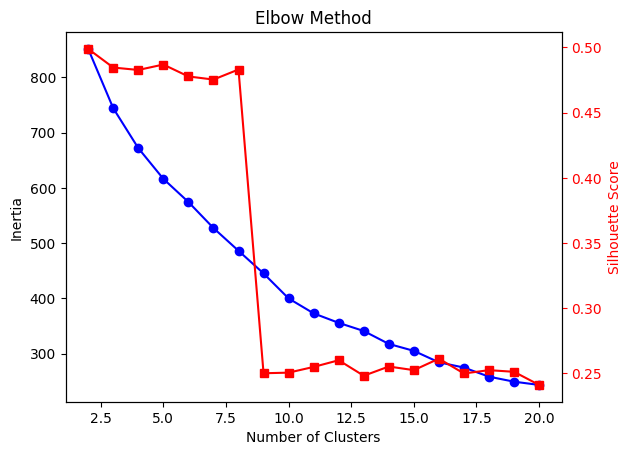

In [48]:
fig, ax1 = plt.subplots()

ax1.plot(range(2, max_clusters+1), inertia, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

# Silhouette 그래프 출력
ax2 = ax1.twinx()
ax2.plot(range(2, max_clusters+1), silhouette_scores, 'rs-')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params('y', colors='r')

plt.show()

>>## 2. Gaussian Mixture
 1. Elbow
 2. Silhouette

In [49]:
max_clusters = 20
n_components = range(2, max_clusters+1)

# 각 클러스터 개수에 따른 BIC 점수와 silhouette_scores 값을 저장하기 위한 빈 리스트 초기화합니다.
bic_scores = []
silhouette_scores = []

# 2부터 max_clusters까지 반복하면서 Gaussian Mixture 모델을 학습합니다.
for k in n_components:
    # Gaussian Mixture 모델 생성 및 학습합니다.
    gmm = GaussianMixture(n_components=k)
    gmm.fit(df_T_scaled)

    # BIC 계산
    bic_scores.append(gmm.bic(df_T_scaled))

    # Silhouette 계수 계산
    s_labels = gmm.predict(df_T_scaled)
    silhouette_avg = silhouette_score(df_T_scaled, s_labels)
    silhouette_scores.append(silhouette_avg)

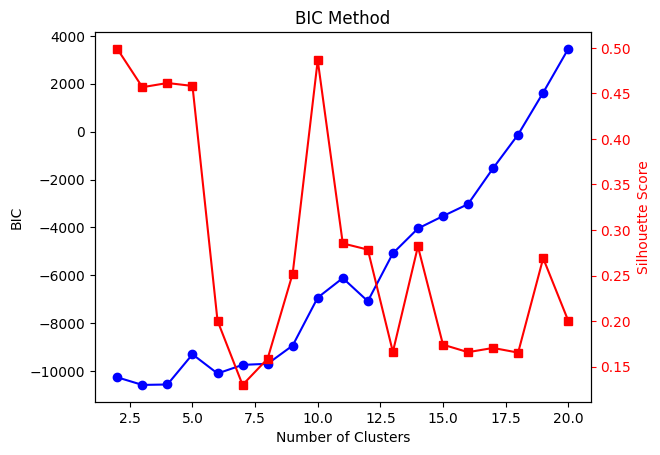

In [50]:
fig, ax1 = plt.subplots()
ax1.plot(n_components, bic_scores, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('BIC')
ax1.set_title('BIC Method')

# Silhouette 그래프 출력
ax2 = ax1.twinx()
ax2.plot(n_components, silhouette_scores, 'rs-')
ax2.set_ylabel('Silhouette Score', color='r')
ax2.tick_params('y', colors='r')

plt.show()

>>## 3. Hierarchy Clustering
1. 덴드로그램(Dendrogram)

 (1) Single linkage

 (2) complete linkage

 (3) average linkage  

덴드로그램은 클러스터의 병합 단계를 시각화

singe: 두 클러스터 내의 가장 가까운 점 사이의 거리

complete: 가장 먼 점 사이의 거리

average: 모든 점 사이의 평균 거리

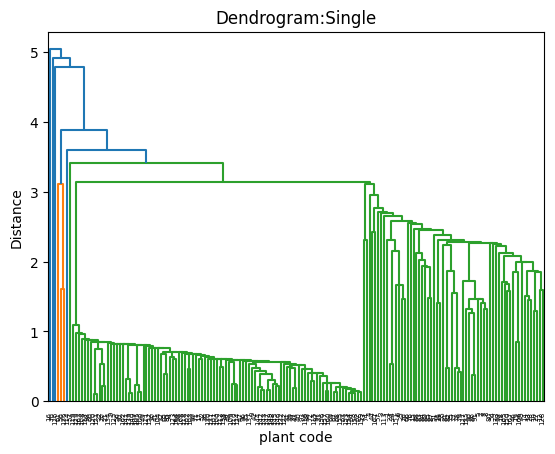

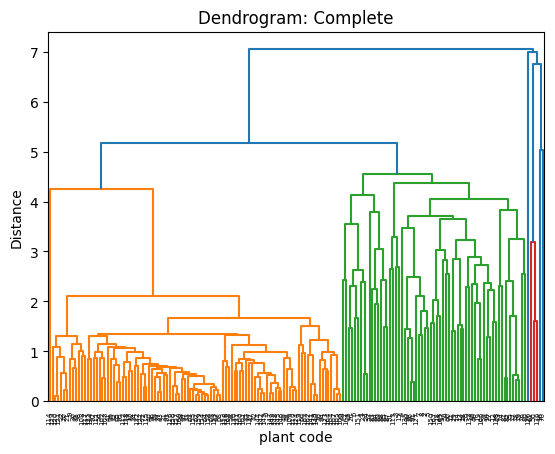

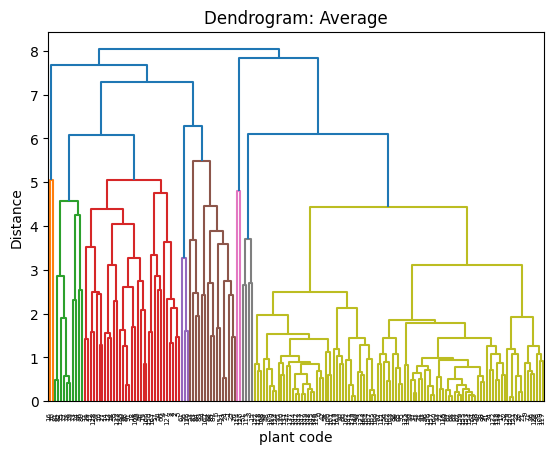

In [51]:
# 계측정 클러스터링을 수행합니다.
# n_clusters 매개변수에 max_clusters 값을 설정하여 최대 클러스터 개수를 지정합니다.
hc = AgglomerativeClustering(n_clusters=max_clusters)

# scaled_features2 데이터를 학습합니다.
hc.fit(df_T_scaled)

# 가장 가까운 두 개의 클러스터 사이의 거리를 측정합니다.
hc_single = linkage(df_T_scaled, method='single')
# 두 클러스터 내 모든 점 사이의 평균 거리를 측정합니다.
hc_avg = linkage(df_T_scaled, method='average')
# 가장 먼 두 개의 클러스터 사이의 거리를 측정합니다.
hc_complete = linkage(df_T_scaled, method='complete')

# Single linkage
plt.xlabel('plant code')
plt.ylabel('Distance')
plt.title('Dendrogram:Single')
dendrogram(hc_single)
plt.show()

# Complete linkage
plt.xlabel('plant code')
plt.ylabel('Distance')
plt.title('Dendrogram: Complete')
dendrogram(hc_avg)
plt.show()

# Average linkage
plt.xlabel('plant code')
plt.ylabel('Distance')
plt.title('Dendrogram: Average')
dendrogram(hc_complete)
plt.show()

>> ## 4. DBSCAN

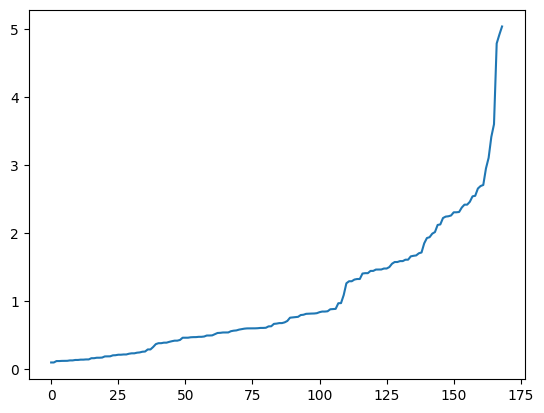

In [52]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_T_scaled)
distances, indices = neighbors_fit.kneighbors(df_T_scaled)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [53]:
distances

array([0.0974198 , 0.0974198 , 0.11831909, 0.11831909, 0.12068553,
       0.12068553, 0.1218516 , 0.12782617, 0.12782617, 0.13439969,
       0.13439969, 0.13908216, 0.13908216, 0.14230043, 0.14230043,
       0.16024252, 0.16024252, 0.16734299, 0.16734299, 0.16983845,
       0.18662423, 0.18662423, 0.18807556, 0.20243205, 0.20431087,
       0.21142251, 0.21142251, 0.21529653, 0.21529653, 0.22602098,
       0.23209687, 0.23209687, 0.24139058, 0.24541616, 0.25558025,
       0.25855154, 0.28923672, 0.28923672, 0.32488133, 0.36737978,
       0.38110717, 0.38110717, 0.38901115, 0.38901115, 0.40084732,
       0.41051315, 0.41849406, 0.41849406, 0.42866683, 0.46164152,
       0.46195015, 0.46195015, 0.46821224, 0.47033686, 0.470799  ,
       0.47497643, 0.47497643, 0.4793887 , 0.49420512, 0.49420512,
       0.49614046, 0.51351554, 0.53152092, 0.53361664, 0.5386739 ,
       0.5386739 , 0.53938681, 0.5577744 , 0.56531877, 0.5690961 ,
       0.58076532, 0.58862916, 0.59514761, 0.59895963, 0.59895

In [54]:
min_samples = range(4,5)
eps = distances

In [55]:
# output = []


# for ep in eps:
#     labels = DBSCAN(min_samples=4, eps = ep).fit_predict(df_T_scaled)
#     score = silhouette_score(df_T_scaled, labels)
#     output.append((4, ep, score))

In [56]:
# min_samples, eps, score = sorted(output, key=lambda x:x[-1])[-1]
# print(f"Best silhouette_score: {score}")
# print(f"min_samples: {min_samples}")
# print(f"eps: {eps}")

># iii. 클러스터링 알고리즘 적용
1. K-MEANS
2. Gaussian Mixture
3. Hierarchy Clustering
4. DBSCAN

>>## 1. K-MEANS

In [57]:
# K-means 알고리즘을 사용하여 클러스터링 모델 학습
kmeans = KMeans(n_clusters=8, init='k-means++')  # 클러스터 개수는 상황에 맞게 설정합니다
kmeans.fit(df_T_scaled)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans()

In [58]:
# km = TimeSeriesKMeans(n_clusters=7, metric="dtw")
# km.fit(df_T_scaled)
labels = kmeans.fit_predict(df_T_scaled)
# 학습된 클러스터링 모델로 데이터를 예측 (각 데이터 포인트가 속한 클러스터를 예측)

cluster_count = math.ceil(math.sqrt(len(set(labels))))
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [59]:
print(labels)
score = silhouette_score(df_T_scaled, labels)
print(score)

[0 4 1 5 1 1 4 1 1 2 5 5 5 5 5 5 7 0 6 6 2 2 2 4 4 4 4 5 5 5 0 2 2 2 2 0 2
 2 2 2 2 0 0 2 4 6 5 0 0 0 4 5 0 4 6 5 2 6 2 5 0 4 2 2 2 2 6 2 2 2 7 2 2 3
 3 3 3 3 3 3 6 3 3 4 4 4 6 4 4 4 6 6 2 2 0 2 2 0 2 2 0 0 2 2 0 0 0 0 2 0 0
 2 2 5 2 2 0 2 2 0 2 2 2 0 0 2 3 1 5 2 2 0 0 5 2 1 4 0 2 0 0 0 0 0 0 0 0 0
 0 0 6 4 2 2 2 2 2 2 2 2 2 1 0 0 0 6 6 6 0]
0.23127827624084907


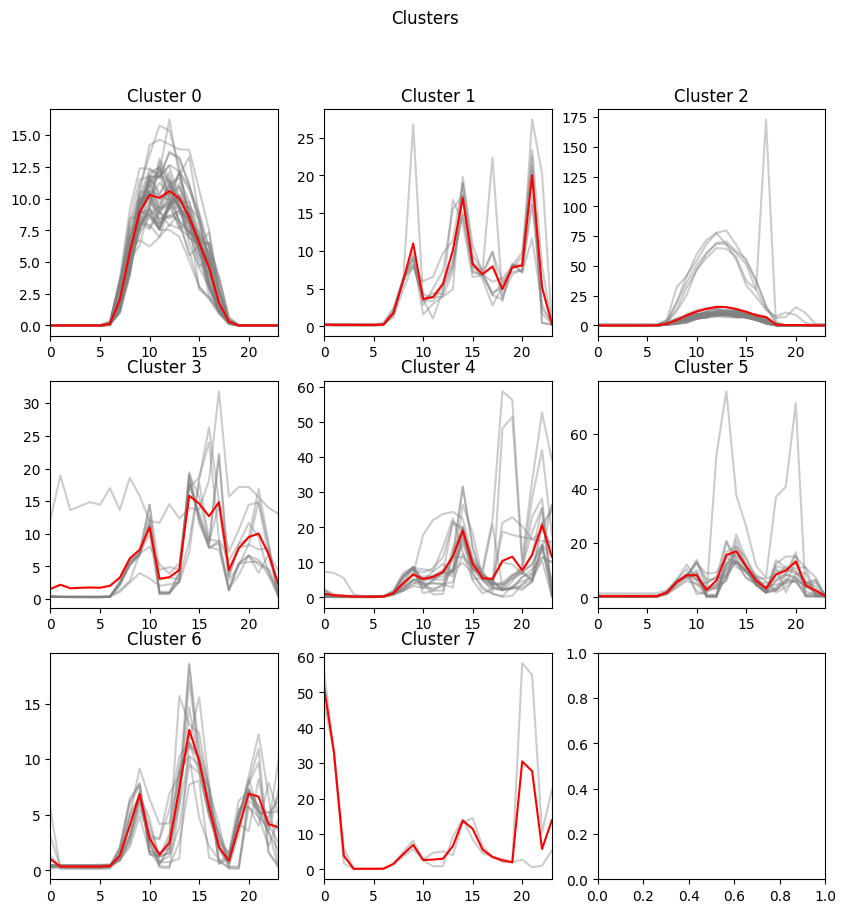

In [60]:
plot_count = math.ceil(math.sqrt(len(set(labels))))


fig, axs = plt.subplots(plot_count,plot_count,figsize=(10,10))
fig.suptitle('Clusters')
row_i=0
column_j=0

cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []

# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], df_pivot[plant_list[i]] ,c="gray",alpha=0.4)
                cluster.append(df_pivot[plant_list[i]])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
    axs[row_i, column_j].set_xlim(0, 23)
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

    if label == 0:
      cluster0.append(np.average(np.vstack(cluster),axis=0))
    if label == 1:
      cluster1.append(np.average(np.vstack(cluster),axis=0))
    if label == 2:
      cluster2.append(np.average(np.vstack(cluster),axis=0))
    if label == 3:
      cluster3.append(np.average(np.vstack(cluster),axis=0))
    if label == 4:
      cluster4.append(np.average(np.vstack(cluster),axis=0))
    if label == 5:
      cluster5.append(np.average(np.vstack(cluster),axis=0))
    if label == 6:
      cluster6.append(np.average(np.vstack(cluster),axis=0))

plt.show()

In [61]:
# 각 클러스터의 9시 ~ 16시 오차율 평균
print(cluster0[0][9:17])
print(cluster1[0][9:17])
print(cluster2[0][9:17])
print(cluster3[0][9:17])
print(cluster4[0][9:17])
print(cluster5[0][9:17])
print(cluster6[0][9:17])

[ 8.94977077 10.29310804 10.06096395 10.59957932 10.01826587  8.53420435
  6.52929947  4.56403966]
[10.99037908  3.6186192   3.89088066  5.63262884 10.05025003 17.02650346
  8.25938497  6.91418342]
[ 8.46821927 11.65104522 13.97398548 15.54862381 15.42133682 13.81831471
 11.5349718   8.53483575]
[ 7.54431752 10.96431271  3.09873118  3.34737592  4.44101456 15.82083357
 14.6320196  12.68156544]
[ 6.58590599  5.27881229  5.8563522   7.29390532 11.66452961 19.09452359
  9.59053255  5.48863505]
[ 8.14713249  8.11850329  2.65478797  6.27599752 15.60167985 16.99631172
 11.40515825  6.15435754]
[ 6.85096555  2.87152226  1.40544048  2.47171842  7.31219362 12.63855007
  9.863916    5.66975847]


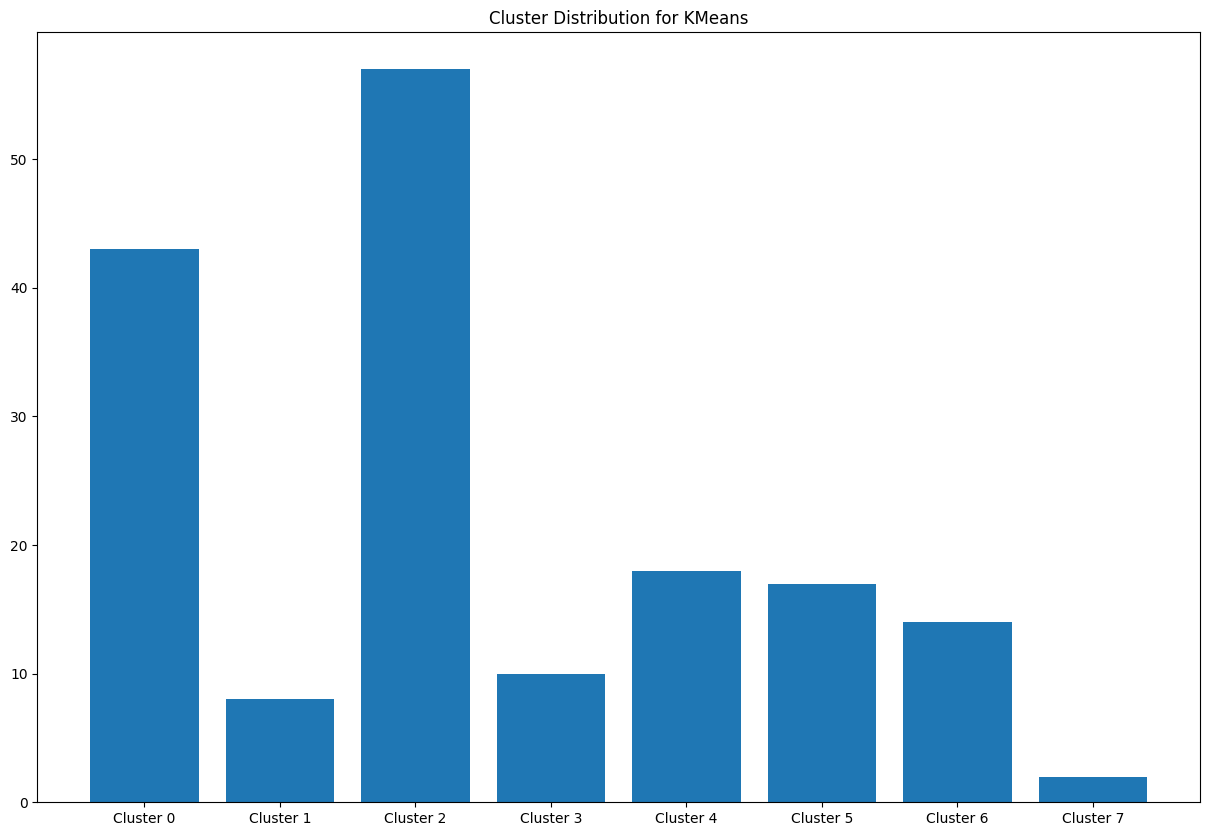

In [62]:
cluster_c = [len(labels[labels==i]) for i in range(len(set(labels)))]
cluster_n = ["Cluster "+str(i) for i in range(len(set(labels)))]
plt.figure(figsize=(15,10))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [63]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
p = pd.DataFrame(zip(plant_list,fancy_names_for_labels),columns=["plant code","Cluster"]).sort_values(by="Cluster").set_index("Cluster")
p = p.sort_index()

In [64]:
p

,plant code
Cluster,
Cluster 0,B1727
Cluster 0,S5025
Cluster 0,S5019
Cluster 0,S5018
Cluster 0,S5016
...,...
Cluster 6,B1777
Cluster 6,G1051
Cluster 6,N6004


In [65]:
k_df = pd.DataFrame({
    # "Cluster_0" : p['plant code'][0:cluster_c[0]],
    # "Cluster_1" : p['plant code'][cluster_c[0]:cluster_c[0] + cluster_c[1]],
    # "Cluster_2" : p['plant code'][cluster_c[0] + cluster_c[1]:cluster_c[0] + cluster_c[1] + cluster_c[2]],
    # "Cluster_3" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3]],
    # "Cluster_4" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4]],
    "Cluster_5" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5]],
    # "Cluster_6" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6]],
    })

display(k_df)
outlier = k_df.values.tolist()

,Cluster_5
Cluster,
Cluster 5,S5022
Cluster 5,B1786
Cluster 5,G1026
Cluster 5,G1031
Cluster 5,G1053
Cluster 5,B1730
Cluster 5,B1737
Cluster 5,B1741
Cluster 5,B1739


In [66]:
# list to string
flat_list = [item for sublist in outlier for item in sublist]
print(flat_list)

['S5022', 'B1786', 'G1026', 'G1031', 'G1053', 'B1730', 'B1737', 'B1741', 'B1739', 'B1740', 'B1742', 'S5042', 'B1788', 'B1787', 'S5037', 'B1738', 'G1039']


In [67]:
sum = 0
for i in flat_list:
  sum += df_actual[i][16]
print(sum)

66714.06


>>## 2. Gaussian Mixture

In [68]:
gmm = GaussianMixture(n_components = 8)
gmm.fit(df_T_scaled)
labels = gmm.fit_predict(df_T_scaled)
labels

array([1, 2, 3, 5, 3, 3, 2, 3, 3, 4, 5, 5, 5, 5, 5, 5, 4, 1, 3, 3, 4, 4,
       4, 2, 2, 2, 2, 5, 5, 5, 1, 1, 7, 1, 1, 1, 7, 1, 1, 1, 1, 7, 1, 1,
       2, 3, 5, 1, 1, 1, 6, 5, 1, 2, 3, 5, 7, 3, 1, 5, 1, 6, 1, 1, 1, 7,
       3, 1, 1, 1, 3, 7, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 3, 2,
       2, 2, 3, 3, 7, 1, 1, 7, 1, 1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1,
       1, 7, 1, 5, 4, 1, 1, 7, 1, 1, 4, 4, 1, 1, 1, 7, 0, 3, 5, 4, 1, 1,
       1, 5, 7, 3, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 7, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 3, 1])

In [69]:
labels
score = silhouette_score(df_T_scaled, labels)
print(score)

0.18427382238246806


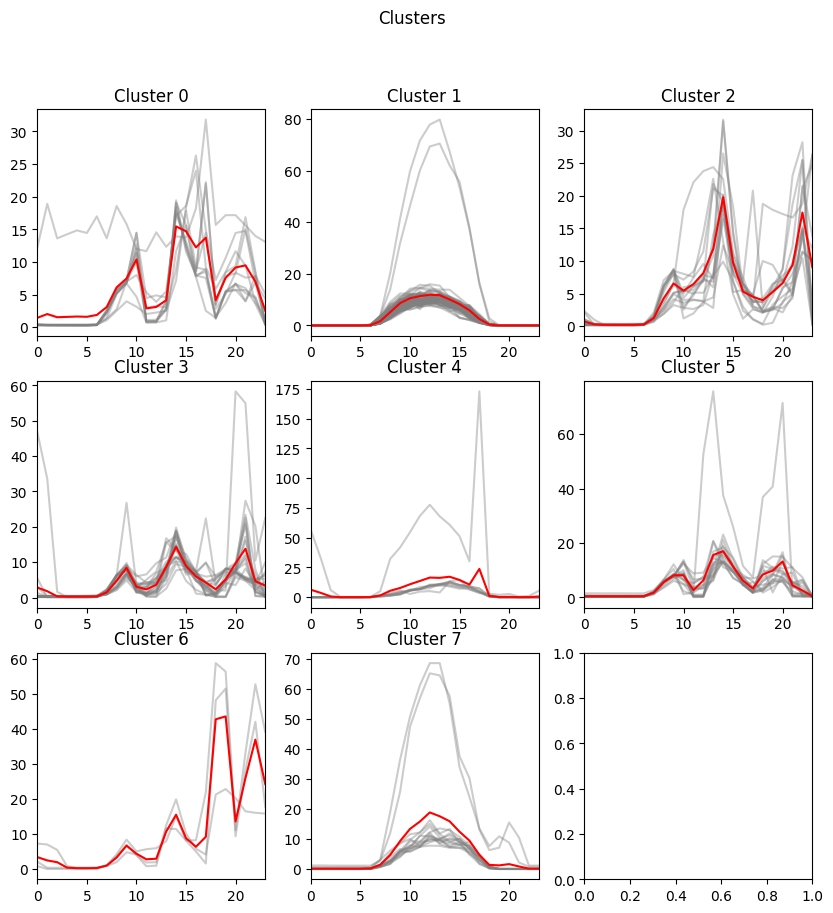

In [70]:
plot_count = math.ceil(math.sqrt(len(set(labels))))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(10,10))
fig.suptitle('Clusters')
row_i=0
column_j=0

cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []

# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], df_pivot[plant_list[i]], c="gray",alpha=0.4)
                cluster.append(df_pivot[plant_list[i]])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
    axs[row_i, column_j].set_xlim(0, 23)
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

    if label == 0:
      cluster0.append(np.average(np.vstack(cluster),axis=0))
    if label == 1:
      cluster1.append(np.average(np.vstack(cluster),axis=0))
    if label == 2:
      cluster2.append(np.average(np.vstack(cluster),axis=0))
    if label == 3:
      cluster3.append(np.average(np.vstack(cluster),axis=0))
    if label == 4:
      cluster4.append(np.average(np.vstack(cluster),axis=0))
    if label == 5:
      cluster5.append(np.average(np.vstack(cluster),axis=0))
    if label == 6:
      cluster6.append(np.average(np.vstack(cluster),axis=0))
    if label == 7:
      cluster7.append(np.average(np.vstack(cluster),axis=0))


plt.show()

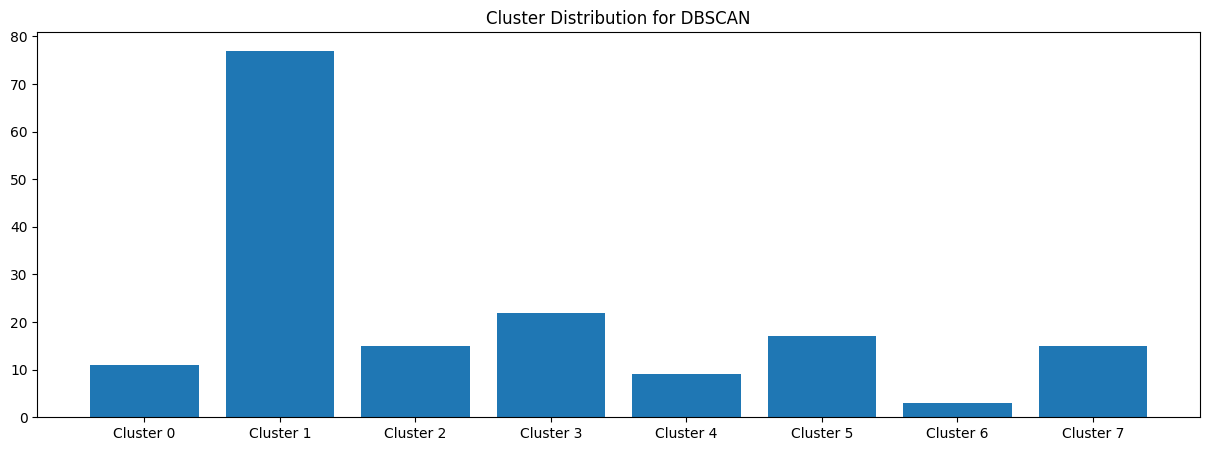

In [71]:
cluster_c = [len(labels[labels==i]) for i in range(len(set(labels)))]
cluster_n = ["Cluster "+str(i) for i in range(len(set(labels)))]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for DBSCAN")
plt.bar(cluster_n,cluster_c)
plt.show()

In [72]:
# 각 클러스터의 9시 ~ 16시 오차율 평균
print(cluster0[0][9:17])
print(cluster1[0][9:17])
print(cluster2[0][9:17])
print(cluster3[0][9:17])
print(cluster4[0][9:17])
print(cluster5[0][9:17])
print(cluster6[0][9:17])
print(cluster7[0][9:17])

[ 7.46764856 10.3925744   2.88304745  3.10981905  4.13293    15.44475252
 14.71679641 12.2335943 ]
[ 8.62874031 10.54186998 11.35508991 11.90292709 11.74487352 10.06547687
  8.26411083  5.87557511]
[ 6.55503936  5.44727896  6.46002724  8.1503708  11.85002425 19.80322358
  9.73445215  5.30510499]
[ 8.42179538  3.04577501  2.31607711  3.6290007   8.67643566 14.34987523
  8.95804952  5.97930271]
[ 7.75416806 10.87396713 13.64942398 16.49983852 16.2642599  17.2094671
 14.49574136 10.59549533]
[ 8.14713249  8.11850329  2.65478797  6.27599752 15.60167985 16.99631172
 11.40515825  6.15435754]
[ 6.74023914  4.43647895  2.83797701  3.01157795 10.73705645 15.55102363
  8.87093457  6.40628531]
[ 9.26964392 13.32518935 15.77418828 18.80861405 17.53781362 15.86675104
 12.39583289  9.4330878 ]


In [73]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
p = pd.DataFrame(zip(plant_list,fancy_names_for_labels),columns=["plant code","Cluster"]).sort_values(by="Cluster").set_index("Cluster")
p = p.sort_index()

In [74]:
# gm_df = pd.DataFrame({
#     # "Cluster_0" : p['plant code'][0:cluster_c[0]],
#     # "Cluster_1" : p['plant code'][cluster_c[0]:cluster_c[0] + cluster_c[1]],
#     # "Cluster_2" : p['plant code'][cluster_c[0] + cluster_c[1]:cluster_c[0] + cluster_c[1] + cluster_c[2]],
#     # "Cluster_3" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3]],
#     # "Cluster_4" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4]],
#     # "Cluster_5" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5]],
#     # "Cluster_6" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6]],
#     "Cluster_7" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6] + cluster_c[7]],
# })

# display(gm_df)
# outlier = gm_df.values.tolist()

In [75]:
# list to string
flat_list = [item for sublist in outlier for item in sublist]
print(flat_list)

['S5022', 'B1786', 'G1026', 'G1031', 'G1053', 'B1730', 'B1737', 'B1741', 'B1739', 'B1740', 'B1742', 'S5042', 'B1788', 'B1787', 'S5037', 'B1738', 'G1039']


In [76]:
sum = 0
for i in flat_list:
  sum += df_actual[i][16]
print(sum)

66714.06


>>## 3. Hierarchy Clustering

In [77]:
hcluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='average')
labels = hcluster.fit_predict(df_T_scaled)
labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([0, 2, 1, 3, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 3, 5, 0, 1, 1, 0, 0,
       0, 2, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 1, 0, 0, 0, 7, 3, 0, 2, 1, 1, 0, 1, 0, 1, 0, 7, 0, 0, 0, 0,
       1, 0, 0, 0, 4, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2,
       2, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 1, 0])

In [78]:
labels
score = silhouette_score(df_T_scaled, labels)
print(score)

0.47575514753602427


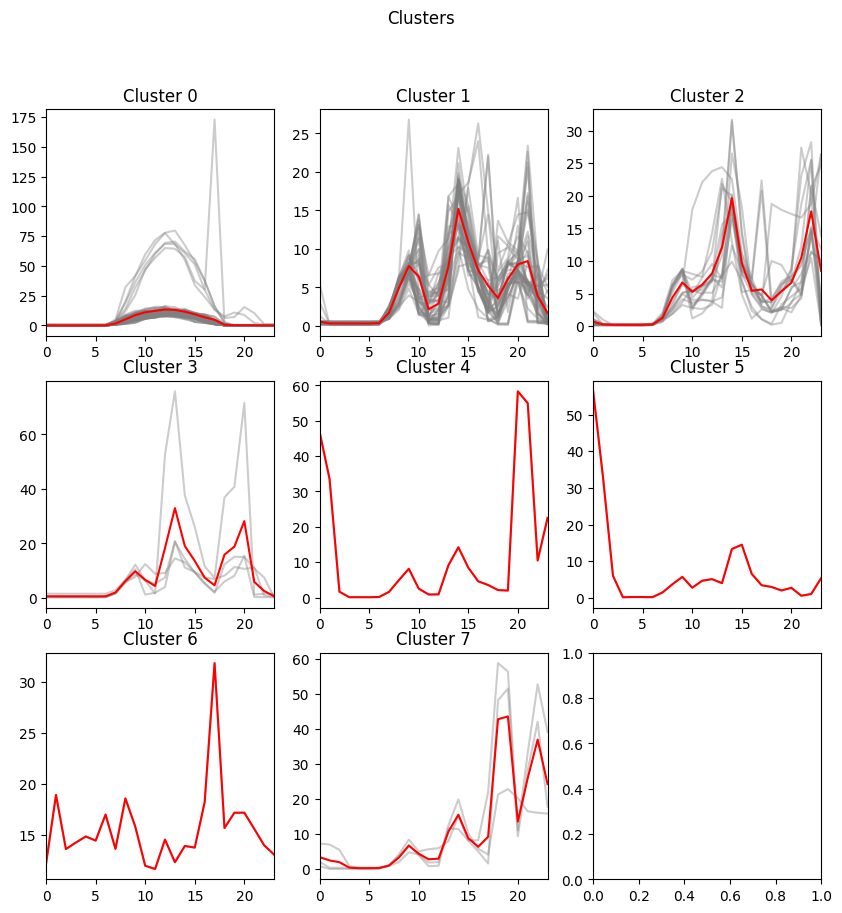

In [79]:
plot_count = math.ceil(math.sqrt(len(set(labels))))


fig, axs = plt.subplots(plot_count,plot_count,figsize=(10,10))
fig.suptitle('Clusters')
row_i=0
column_j=0

cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
cluster7 = []
cluster8 = []
cluster9 = []



# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], df_pivot[plant_list[i]], c="gray",alpha=0.4)
                cluster.append(df_pivot[plant_list[i]])


    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
    axs[row_i, column_j].set_xlim(0, 23)
    column_j+=1

    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

    if label == 0:
      cluster0.append(np.average(np.vstack(cluster),axis=0))
    if label == 1:
      cluster1.append(np.average(np.vstack(cluster),axis=0))
    if label == 2:
      cluster2.append(np.average(np.vstack(cluster),axis=0))
    if label == 3:
      cluster3.append(np.average(np.vstack(cluster),axis=0))
    if label == 4:
      cluster4.append(np.average(np.vstack(cluster),axis=0))
    if label == 5:
      cluster5.append(np.average(np.vstack(cluster),axis=0))
    if label == 6:
      cluster6.append(np.average(np.vstack(cluster),axis=0))
    if label == 7:
      cluster7.append(np.average(np.vstack(cluster),axis=0))
    if label == 8:
      cluster8.append(np.average(np.vstack(cluster),axis=0))
    if label == 9:
      cluster9.append(np.average(np.vstack(cluster),axis=0))




plt.show()

In [80]:
# 각 클러스터의 9시 ~ 16시 오차율 평균
# print(cluster0[0][9:17])
# print(cluster1[0][9:17])
# print(cluster2[0][9:17])
# print(cluster3[0][9:17])
# print(cluster4[0][9:17])
# print(cluster5[0][9:17])
# print(cluster6[0][9:17])
# print(cluster7[0][9:17])
# print(cluster8[0][9:17])
# print(cluster9[0][9:17])

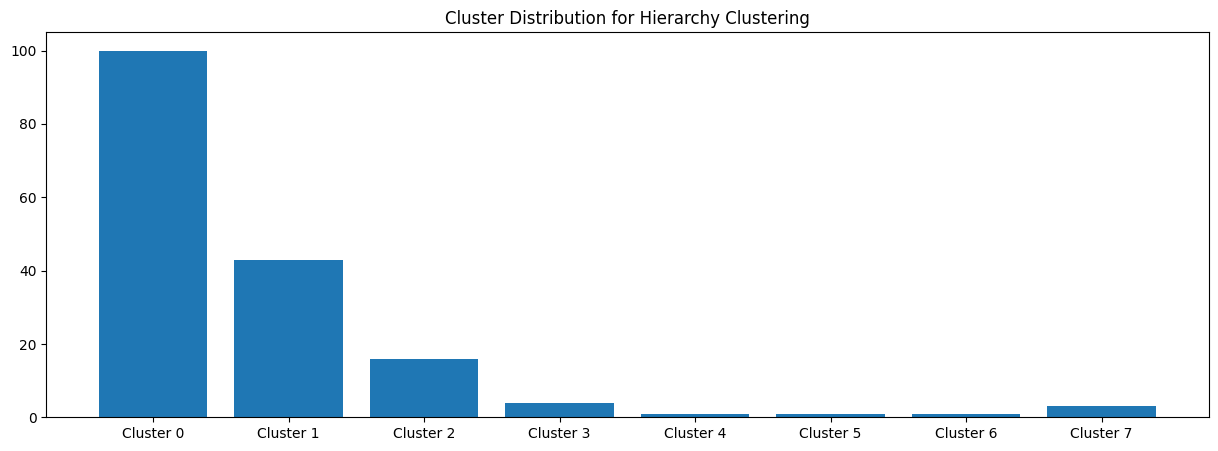

In [81]:
cluster_c = [len(labels[labels==i]) for i in range(len(set(labels)))]
cluster_n = ["Cluster "+str(i) for i in range(len(set(labels)))]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for Hierarchy Clustering")
plt.bar(cluster_n,cluster_c)
plt.show()

In [82]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
p = pd.DataFrame(zip(plant_list,fancy_names_for_labels),columns=["plant code","Cluster"]).sort_values(by="Cluster").set_index("Cluster")
p = p.sort_index()

In [83]:
p

,plant code
Cluster,
Cluster 0,B1727
Cluster 0,S5029
Cluster 0,S5028
Cluster 0,S5027
Cluster 0,S5026
...,...
Cluster 5,B1743
Cluster 6,S5035
Cluster 7,G1030


In [84]:
p['plant code']

Cluster
Cluster 0    B1727
Cluster 0    S5029
Cluster 0    S5028
Cluster 0    S5027
Cluster 0    S5026
             ...  
Cluster 5    B1743
Cluster 6    S5035
Cluster 7    G1030
Cluster 7    G1055
Cluster 7    S5045
Name: plant code, Length: 169, dtype: object

In [85]:
# hc_df = pd.DataFrame({
#     # "Cluster_0" : p['plant code'][0:cluster_c[0]],
#     # "Cluster_1" : p['plant code'][cluster_c[0]:cluster_c[0] + cluster_c[1]],
#     # "Cluster_2" : p['plant code'][cluster_c[0] + cluster_c[1]:cluster_c[0] + cluster_c[1] + cluster_c[2]],
#     # "Cluster_3" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3]],
#     # "Cluster_4" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4]],
#     # "Cluster_5" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5]],
#     # "Cluster_6" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6]],
#     # "Cluster_7" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6] + cluster_c[7]],
#     # "Cluster_8" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6] + cluster_c[7]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6] + cluster_c[7] + cluster_c[8]],
#     "Cluster_9" : p['plant code'][cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6] + cluster_c[7] + cluster_c[8]:cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4] + cluster_c[5] + cluster_c[6] + cluster_c[7] + cluster_c[8] + cluster_c[9]],
# })
# # db_df["Cluster_0"] = p['plant code'][43:141]
# display(hc_df)
# outlier = hc_df.values.tolist()

In [86]:
# list to string
flat_list = [item for sublist in outlier for item in sublist]
print(flat_list)

['S5022', 'B1786', 'G1026', 'G1031', 'G1053', 'B1730', 'B1737', 'B1741', 'B1739', 'B1740', 'B1742', 'S5042', 'B1788', 'B1787', 'S5037', 'B1738', 'G1039']


In [87]:
sum = 0
for i in flat_list:
  sum += df_actual[i][16]
print(sum)

66714.06


In [88]:
p

,plant code
Cluster,
Cluster 0,B1727
Cluster 0,S5029
Cluster 0,S5028
Cluster 0,S5027
Cluster 0,S5026
...,...
Cluster 5,B1743
Cluster 6,S5035
Cluster 7,G1030


>>## 4. DBSCAN

In [89]:
# labels = dbscan_dtw(df_T_scaled, eps=0.5, min_samples=3)

In [90]:
distances

array([0.0974198 , 0.0974198 , 0.11831909, 0.11831909, 0.12068553,
       0.12068553, 0.1218516 , 0.12782617, 0.12782617, 0.13439969,
       0.13439969, 0.13908216, 0.13908216, 0.14230043, 0.14230043,
       0.16024252, 0.16024252, 0.16734299, 0.16734299, 0.16983845,
       0.18662423, 0.18662423, 0.18807556, 0.20243205, 0.20431087,
       0.21142251, 0.21142251, 0.21529653, 0.21529653, 0.22602098,
       0.23209687, 0.23209687, 0.24139058, 0.24541616, 0.25558025,
       0.25855154, 0.28923672, 0.28923672, 0.32488133, 0.36737978,
       0.38110717, 0.38110717, 0.38901115, 0.38901115, 0.40084732,
       0.41051315, 0.41849406, 0.41849406, 0.42866683, 0.46164152,
       0.46195015, 0.46195015, 0.46821224, 0.47033686, 0.470799  ,
       0.47497643, 0.47497643, 0.4793887 , 0.49420512, 0.49420512,
       0.49614046, 0.51351554, 0.53152092, 0.53361664, 0.5386739 ,
       0.5386739 , 0.53938681, 0.5577744 , 0.56531877, 0.5690961 ,
       0.58076532, 0.58862916, 0.59514761, 0.59895963, 0.59895

In [91]:
eps = distances[15:]

output = []

for ep in eps:
    labels = DBSCAN(min_samples=4, eps = ep, metric='euclidean').fit_predict(df_T_scaled)

    score = silhouette_score(df_T_scaled, labels)
    output.append((4, ep, score))

output.sort(key=lambda x:-x[2])

In [92]:
print(output)

[(4, 3.1089553351422747, 0.49755704149517516), (4, 1.2623624503333615, 0.4959411192521596), (4, 1.2926092466612789, 0.4959411192521596), (4, 1.2926092466612789, 0.4959411192521596), (4, 2.951640521818614, 0.490912725535337), (4, 0.9709449299045646, 0.48630205774780216), (4, 1.0887015069418715, 0.48630205774780216), (4, 2.70901935738561, 0.4818399642511404), (4, 2.656951004034105, 0.47570238295336226), (4, 2.693390434016953, 0.47570238295336226), (4, 0.8862901103880556, 0.4694174071821983), (4, 0.969071270891657, 0.4694174071821983), (4, 4.791308990455489, 0.4678776107659198), (4, 4.921564690335781, 0.461478127860504), (4, 5.041246501735102, 0.461478127860504), (4, 0.8826549016224258, 0.45105642130106116), (4, 2.3773191708882124, 0.44374640149200767), (4, 0.8799860553858205, 0.44253226270351065), (4, 2.4196416673173315, 0.4413628505007763), (4, 2.4196416673173315, 0.4413628505007763), (4, 2.3116263146366953, 0.435802740793539), (4, 3.6034057618018998, 0.43538939945785865), (4, 2.4619127

In [93]:
# dbscan = DBSCAN(eps=3.1089553351422747, min_samples=4, metric='euclidean')
# labels = dbscan.fit_predict(df_T_scaled)
# print(labels)

In [94]:
dbscan = DBSCAN(eps=2.2, min_samples=5, metric='euclidean')
labels = dbscan.fit_predict(df_T_scaled)
print(labels)

[ 0 -1  1 -1 -1  1 -1  1  1  0  2 -1  2 -1 -1 -1 -1  0  4  4  0  0  0 -1
 -1 -1 -1  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  2  4  0
  0  0 -1 -1  0 -1 -1 -1  0 -1  0  2  0 -1  0  0  0  0 -1  0  0  0 -1  0
  0 -1 -1  3 -1  3  3  3 -1  3  3 -1 -1 -1  1 -1 -1 -1  1  1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0
  0  0  0  0  0  0 -1  1  2  0  0  0  0 -1  0  1 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  4 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  4  4  4
  0]


In [95]:
labels
score = silhouette_score(df_T_scaled, labels)
print(score)

0.40069981815250594


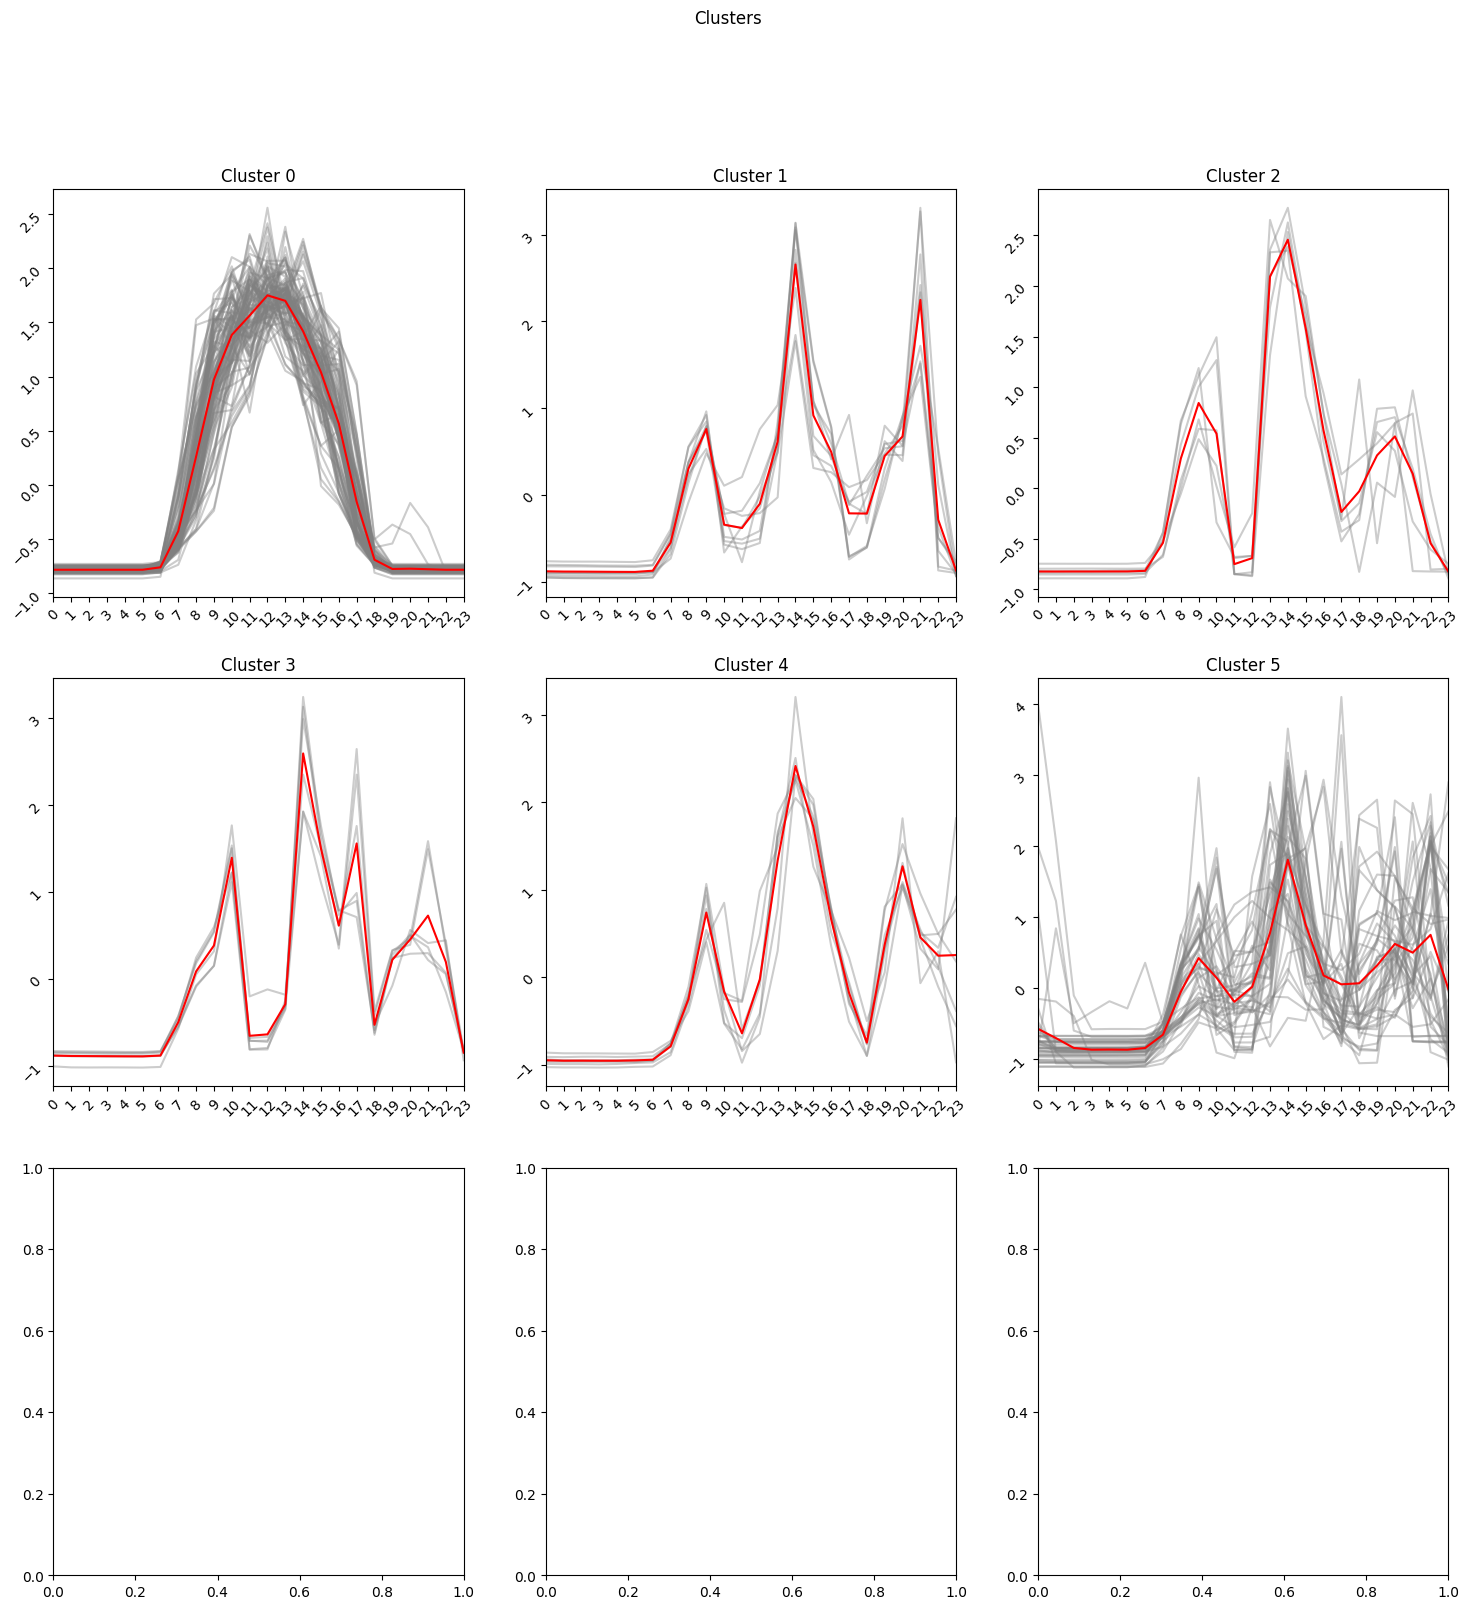

In [96]:
plot_count = math.ceil(math.sqrt(len(set(labels))))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(18,18))
fig.suptitle('Clusters')
row_i=0
column_j=0

cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []


# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []

    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], df_scaled[plant_list[i]] ,c="gray",alpha=0.4)

                axs[row_i, column_j].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])
                axs[row_i, column_j].tick_params(labelrotation=45)
                # df_inverse_scaled[plant_list[i]]
                cluster.append(df_scaled[plant_list[i]].values)

    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
    axs[row_i, column_j].set_xlim(0, 23)
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
    if label == 0:
      cluster0.append(np.average(np.vstack(cluster),axis=0))
    if label == 1:
      cluster1.append(np.average(np.vstack(cluster),axis=0))
    if label == 2:
      cluster2.append(np.average(np.vstack(cluster),axis=0))
    if label == 3:
      cluster3.append(np.average(np.vstack(cluster),axis=0))
    if label == 4:
      cluster4.append(np.average(np.vstack(cluster),axis=0))
    if label == -1:
      cluster5.append(np.average(np.vstack(cluster),axis=0))

plt.show()

In [97]:
# # 각 클러스터의 9시 ~ 16시 오차율 평균
# print(cluster0[0][9:17])
# print(cluster1[0][9:17])
# print(cluster2[0][9:17])
# print(cluster3[0][9:17])
# print(cluster4[0][9:17])
# print(cluster5[0][9:17])

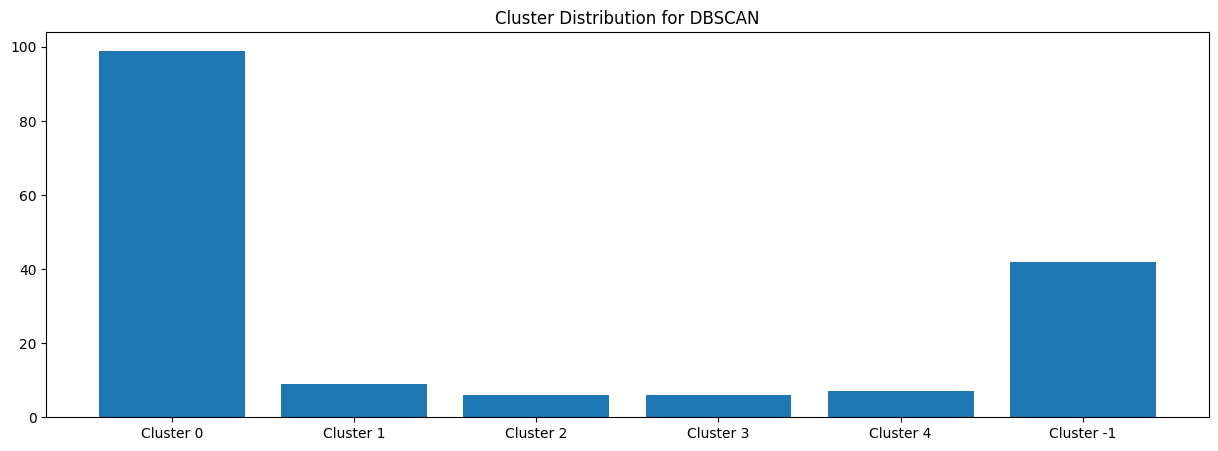

In [98]:
cluster_c = [len(labels[labels==i]) for i in range(len(set(labels))-1)]
cluster_c.append(len(labels[labels==-1]))
cluster_n = ["Cluster "+str(i) for i in range(len(set(labels))-1)]
cluster_n.append("Cluster "+str(-1))
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for DBSCAN")
plt.bar(cluster_n,cluster_c)
plt.show()

In [99]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
p = pd.DataFrame(zip(plant_list,fancy_names_for_labels),columns=["plant code","Cluster"]).sort_values(by="Cluster").set_index("Cluster")
p = p.sort_index()

In [100]:
# db_df = pd.DataFrame({
#     # 'Cluster_outlier' : p['plant code'][0:cluster_c[5]],
#     # "Cluster_0" : p['plant code'][cluster_c[5]:cluster_c[5] + cluster_c[0]],
#     # "Cluster_1" : p['plant code'][cluster_c[5] + cluster_c[0]:cluster_c[5] + cluster_c[0] + cluster_c[1]],
#     # "Cluster_2" : p['plant code'][cluster_c[5] + cluster_c[0] + cluster_c[1]:cluster_c[5] + cluster_c[0] + cluster_c[1] + cluster_c[2]],
#     # "Cluster_3" : p['plant code'][cluster_c[5] + cluster_c[0] + cluster_c[1] + cluster_c[2]:cluster_c[5] + cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3]],
#     "Cluster_4" : p['plant code'][cluster_c[5] + cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3]:cluster_c[5] + cluster_c[0] + cluster_c[1] + cluster_c[2] + cluster_c[3] + cluster_c[4]],
# })
# # db_df["Cluster_0"] = p['plant code'][43:141]
# outlier = db_df.values.tolist()
# db_df

In [101]:
# list to string
flat_list = [item for sublist in outlier for item in sublist]
print(flat_list)

['S5022', 'B1786', 'G1026', 'G1031', 'G1053', 'B1730', 'B1737', 'B1741', 'B1739', 'B1740', 'B1742', 'S5042', 'B1788', 'B1787', 'S5037', 'B1738', 'G1039']


In [102]:
sum = 0
for i in flat_list:
  sum += df_actual[i][16]
print(sum)

66714.06


In [103]:
df_scaled

발전소코드,B1727,B1728,B1729,B1730,B1731,B1732,B1733,B1734,B1735,B1736,...,V9018,V9019,V9020,V9021,V9022,V9023,V9024,V9025,V9026,V9027
hour,,,,,,,,,,,,,,,,,,,,,
0,-0.809595,-0.779465,-0.952293,-1.019498,-0.852236,-0.949074,-1.058141,-0.900284,-0.885432,-0.771808,...,-0.784967,-0.793990,-0.894803,-0.817479,-0.771701,-0.790458,-0.862426,-0.969692,-0.911508,-0.826868
1,-0.809595,-0.894769,-0.955589,-1.028251,-0.865276,-0.957896,-1.058184,-0.900074,-0.890037,-0.771808,...,-0.784967,-0.793990,-0.895571,-0.817479,-0.771701,-0.790458,-0.869983,-0.969722,-0.914106,-0.826868
2,-0.809595,-0.905971,-0.957092,-1.028443,-0.866245,-0.958958,-1.058244,-0.899382,-0.890825,-0.771808,...,-0.784967,-0.793990,-0.895907,-0.817479,-0.771701,-0.790458,-0.870395,-0.969762,-0.909592,-0.826868
3,-0.809595,-0.906690,-0.956797,-1.028693,-0.866713,-0.960409,-1.058347,-0.898490,-0.891871,-0.771808,...,-0.784967,-0.793990,-0.895698,-0.817479,-0.771701,-0.790458,-0.871424,-0.969472,-0.908752,-0.826868
4,-0.809595,-0.906547,-0.957528,-1.028943,-0.866899,-0.960944,-1.058535,-0.897819,-0.893554,-0.771808,...,-0.784967,-0.793990,-0.896723,-0.817479,-0.771701,-0.790458,-0.872953,-0.970910,-0.912436,-0.826868
5,-0.809595,-0.903417,-0.958031,-1.028359,-0.866884,-0.961158,-1.059293,-0.897137,-0.894048,-0.771808,...,-0.784967,-0.793990,-0.896791,-0.817479,-0.771671,-0.790458,-0.874051,-0.972307,-0.907972,-0.826868
6,-0.793189,-0.901208,-0.952259,-1.023270,-0.860614,-0.949479,-1.047451,-0.893529,-0.884001,-0.762138,...,-0.762985,-0.775573,-0.889894,-0.805421,-0.709264,-0.768516,-0.855575,-0.954609,-0.903714,-0.811523
7,-0.417226,-0.830138,-0.679310,-0.777193,-0.649999,-0.624255,-0.746354,-0.732706,-0.604837,-0.473953,...,-0.575932,-0.577824,-0.705562,-0.232935,0.096597,-0.198187,-0.727710,-0.757680,-0.759425,-0.441547
8,0.474248,-0.645153,0.138305,0.026827,0.001878,0.375300,0.248829,-0.084332,0.202736,-0.235875,...,0.037091,-0.018525,-0.093298,0.525613,1.527811,0.960408,-0.388664,-0.205382,-0.110604,0.563441


># iv. Silhouette 계수를 이용하여 적합성을 확인

In [104]:
def get_silhouette_results(X, labels):

    def get_sum_distance(target_x, target_cluster):
        res = np.sum([np.linalg.norm(target_x-x) for x in target_cluster])
        return res

    uniq_labels = np.unique(labels)
    silhouette_val_list = []
    for i in range(len(labels)):
        target_data = X[i]

        ## calculate a(i)
        target_label = labels[i]
        target_cluster_data_idx = np.where(labels==target_label)[0]
        if len(target_cluster_data_idx) == 1:
            silhouette_val_list.append(0)
            continue
        else:
            target_cluster_data = X[target_cluster_data_idx]
            temp1 = get_sum_distance(target_data, target_cluster_data)
            a_i = temp1/(target_cluster_data.shape[0]-1)

        ## calculate b(i)
        b_i_list = []
        label_list = uniq_labels[np.unique(labels) != target_label]
        for ll in label_list:
            other_cluster_data_idx = np.where(labels==ll)[0]
            other_cluster_data = X[other_cluster_data_idx]
            temp2 = get_sum_distance(target_data, other_cluster_data)
            temp_b_i = temp2/other_cluster_data.shape[0]
            b_i_list.append(temp_b_i)

        b_i = min(b_i_list)
        s_i = (b_i-a_i)/max(a_i, b_i)
        silhouette_val_list.append(s_i)

    silhouette_coef_list = []
    for ul in uniq_labels:
        temp3 = np.mean([s for s, l in zip(silhouette_val_list, labels) if l == ul])
        silhouette_coef_list.append(temp3)

    silhouette_coef = max(silhouette_coef_list)
    return (silhouette_coef, np.array(silhouette_val_list))

In [105]:
silhouette_coef, silhouette_list = get_silhouette_results(df_T_scaled, labels)
print(silhouette_coef)

KeyError: ignored

# 시각화


## DBSCAN 클러스터링별 발전소코드 출력

## 발전량 평균 그래프

실측, 예측 데이터 추출하여 확인

In [ ]:
print(df)

In [ ]:
actual_data = df[df['구분1'] == '실측']
predict_data = df[df['구분1'] == '예측']

In [ ]:
# 발전량 데이터가 있는 시간대 열만 추출
a_time_columns = actual_data.columns[4:-1]
p_time_columns = predict_data.columns[4:-1]

In [ ]:
# 실측 발전량 데이터프레임을 actual_mySeries에 추가
for a_time_column in a_time_columns:
    a_series_df = pd.DataFrame({
        "구분1": actual_data["구분1"],
        "발전소코드": actual_data["발전소코드"],
        "발전소용량(KW)": actual_data["발전소용량(KW)"],
        "시간대": a_time_column,
        "발전량": actual_data[a_time_column],
        "합계": actual_data["합계"]
    })

    actual_mySeries.append(a_series_df)
print(a_series_df)

In [ ]:
print(actual_mySeries)

In [ ]:
# 예측 발전량 데이터프레임을 predict_mySeries에 추가
for p_time_column in p_time_columns:
    p_series_df = pd.DataFrame({
        "구분1": predict_data["구분1"],
        "발전소코드": predict_data["발전소코드"],
        "발전소용량(KW)": predict_data["발전소용량(KW)"],
        "시간대" : p_time_column,
        "발전량" : predict_data[p_time_column],
        "합계": predict_data["합계"]
    })
    predict_mySeries.append(p_series_df)

In [ ]:
total_sum = 0

for p_series_df in predict_mySeries:
    sum_values = p_series_df["합계"]
    total_sum += sum_values
for p_time_column in p_time_columns:
  total_sum["발전소코드"] = predict_data["발전소코드"]

print("전체 합계값:", total_sum)

In [ ]:
# a_mean = []

# for i in range(len(actual_mySeries)-1):
# a_mean.append(actual_mySeries[0]["발전량"])

# #막대 그래프
x = [i for i in range(24)]
# y = [df_actual["S5023"][i] for i in range(24)]
# plt.bar(x, y, width=0.7, color="dodgerblue")

# #선 그래프
# cv_list = {
#             'actual':df_actual["S5023"],
#           }
# df = pd.DataFrame.from_dict(cv_list)

plt.plot(x, df_actual["B1780"], color = 'dodgerblue', label="actual")
# plt.show()


# ## 예측 발전량 평균
# p_mean = []

# for i in range(len(predict_mySeries)-1):
# p_mean.append(predict_[i]["발전량"])

# # #막대 그래프
# x = [i for i in range(24)]
# y = [df_predict["S5023"][i] for i in range(0, 24)]
# plt.bar(x, y, width=0.7, color="orange")
plt.xlabel('hour', size = 10) # x축 제목 설정
plt.ylabel('power generation', size = 10)


plt.plot(x, df_predict["B1780"]/1.2, color = 'orange', label="predict")
plt.title('Predicted vs Actual generation graph')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math


# 예측값과 실제값
a1 = 4354523.11 ; b1 = 3511887.23; c1 = 3166034.76; d1 = 4960745.24; e1 = 2475917.15;
f1 = 3308213.12; g1 = 3169832.59

a2 = 4225454.84 ; b2 = 3422719.00; c2 = 3117116.40; d2 = 4789083.64; e2 = 2418353.16;
f2 = 3218884.96; g2 = 3013800.80


# predicted = [ b1,a1,f1,g1,c1,e1,d1]
# predicted = [4354523.11, 3511887.23, 3166034.76, 4960745.24, 2475917.15, 3308213.12, 3169832.59]
# actual = [4225454.84, 3422719.00, 3117116.40, 4789083.64, 2418353.16,3218884.96, 3013800.80]
# actual = [ b2,a2,f2,g2,c2,e2,d2]

predicted = [1088630.7799999998,877971.8099999997, 791508.69, 1240186.31, 618979.2899999996, 827053.2800000014, 792458.1499999997]
actual = [1056363.71, 855679.7500000001, 779279.1000000001, 1205811.8199999998, 604588.2900000003,804721.2400000001, 753450.2000000002]

# 정상금 오차율 계산
error_rates = [abs(a - p) / p * 100 for p, a in zip(predicted, actual)]

# 데이터 포인트 인덱스
indices = np.arange(len(predicted))

# 도표 생성
plt.figure(figsize=(8, 6))
plt.bar(indices, error_rates, color='blue')

# 레이블 및 제목 설정
plt.xlabel('Clustering Numbers')
plt.ylabel('Normalcy Return Error Rate (%)')
plt.title('Normalcy Return Error Rate')

# X축 레이블 위치 및 값 설정
plt.xticks(indices)
plt.gca().set_xticklabels(indices)

# Y축 범위 설정
plt.ylim(min(error_rates) - 1, max(error_rates) + 1)

# 오차율 값 표시
for i, rate in enumerate(error_rates):
    plt.text(i, rate + 0.5, f'{rate:.2f}%', ha='center', va='bottom')

# 도표 출력
plt.show()

># VI. 결론

>>## i. Summary


In [ ]:
result = pd.read_csv('/content/최적_조합_Data_File(win).csv', encoding = 'CP949')
result.head()

In [ ]:
result.describe()

>>## ii. 향후 모델 활용 방안